In [1]:
from anndata import AnnData
import scanpy as sc
from os import path
import os

import numpy as np
from tqdm.auto import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.utilities import deviancePoisson, rescale_spatial_coords
#from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
import random
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.decomposition import NMF
import gpzoo.pri_experiment_utilities as putil
from sklearn.metrics import root_mean_squared_error, mean_poisson_deviance
import torch
#from torch import optim, distributions, nn
#import time
import pandas as pd
from torch import nn
#from sklearn.preprocessing import StandardScaler
#from statsmodels.tsa.stattools import acf
from collections import defaultdict
from matplotlib import cm

In [2]:
random.seed(256)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
root_path = "/engelhardt/home/pshrestha/vnngp/"
SPATH = path.join(root_path, 'results/merfish')
nsf_path = path.join(SPATH, 'nsf')
nnnsf_path = path.join(SPATH, 'nnnsf')
dpth = path.join(root_path, "data/")
merpath = path.join(dpth, "merfish.h5ad")

In [4]:
merpath = path.join(dpth, "merfish.h5ad")
ad = sc.read_h5ad(merpath)
ad = ad[(ad.obs['percent.mt'] < 5), :]
min_genes_per_cell = 500
ad = ad[ad.obs['nFeature_RNA'] >= min_genes_per_cell, :]
min_value = np.min(ad.X)
if min_value < 0:
    ad.X += np.abs(min_value)
ad.var_names_make_unique()
labels = ad.obs.Age.unique()
ad.obs['Age_cat'] = ad.obs['Age'].astype('category')
ad = ad[~ad.obs['Age'].isin([20.8, 22.6, 3.33])]
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
Y = np.array(ad.X, dtype=int).T
X = ad.obsm['X_harmony']
X = X.astype('float32')
Y = Y.astype('float32')
#X = rescale_spatial_coords(X)
ad.uns['counts'] = ad.X.copy()
    
ad.var['deviance_poisson'] = deviancePoisson(ad.uns["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
    
X = np.array(ad.obs['Age'])[:, None]
X = torch.tensor(X, dtype=torch.float)
    
Y = np.log(np.exp(Y) + 1e-2)  # correction
#Y = Y.T

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

/tmp/ipykernel_1116570/2009058706.py:19: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ad.uns['counts'] = ad.X.copy()


X shape:  torch.Size([15582, 1])
Y shape:  (3000, 15582)


In [5]:
print(X.shape)
print(Y.shape)

torch.Size([15582, 1])
(3000, 15582)


### Runtime

In [ ]:
nsf_runtimes = {500: [], 1000: [], 3000: []}
inducing_points = [500, 1000, 3000]
components = [6, 12, 18]
for M in inducing_points:
    for f in components:
        dicts = {
            'L': f, 
            'M': M, 
            'sigma': 0.3, 
            'lengthscale': 0.02, 
            'jtr': 0.01,
            'batch_size': 64,
            'lr': 0.01,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'SVGP',
            'L1_jitter': 1e-1}
        print(f"---------********* M={dicts['M']}  *********---------")
        nmf_save_path = path.join(SPATH, 'nmf')
        factors_path = path.join(nmf_save_path, f"3000/nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
        loadings_path = path.join(nmf_save_path, f"3000/nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
        factors = np.load(factors_path)
        loadings = np.load(loadings_path)
        acf_idx, acf_val = putil.dims_autocorr_timeseries(factors)
        factors = factors[:, acf_idx]
        loadings = loadings[:, acf_idx]
        NSF = putil.build_model(np.array(X), np.array(Y), loadings=np.array(loadings), factors=np.array(factors), model_type='SVGP', kwargs=dicts)
        file_path = f"3000/SVGP_M={dicts['M']}_L={dicts['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_state_dict.pth"
        modelname = f"3000/SVGP_M={dicts['M']}_L={dicts['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_model.pt"
        dict_path = path.join(nsf_path, file_path)
        model_path = path.join(nsf_path, modelname)
        if not path.exists(model_path):
            print(model_path)
            nsf_runtimes[M].append(np.nan)
            print(f"No trained model")
            continue
                
        NSF.load_state_dict(torch.load(dict_path))
        nsf_model_dict = torch.load(model_path)
        print("Runtime: ", (nsf_model_dict['time']))
        nsf_runtimes[M].append(nsf_model_dict['time'])
            #print("RMSE: ", rmse)
        #print("Poisson Deviance: ", poid)

In [ ]:
nnnsf_runtimes = {500: [], 1000: [], 3000: []}
inducing_points = [500, 1000, 3000]
components = [6, 12, 18]
for M in inducing_points:
    for f in components:
        dicts = {
            'L': f, 
            'M': M, 
            'K': 2,
            'sigma': 0.3, 
            'lengthscale': 0.02, 
            'jtr': 0.01,
            'batch_size': 64,
            'lr': 0.01,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'VNNGP',
            'L1_jitter': 1e-1}
        print(f"---------********* M={dicts['M']}  *********---------")
        nmf_save_path = path.join(SPATH, 'nmf')
        factors_path = path.join(nmf_save_path, f"3000/nmf_factors_iter=1000_rs=256_L={dicts['L']}_rm(20.8, 22.6, 3.33)_new.npy")
        loadings_path = path.join(nmf_save_path, f"3000/nmf_loadings_iter=1000_rs=256_L={dicts['L']}_rm(20.8, 22.6, 3.33)_new.npy")
        factors = np.load(factors_path)
        loadings = np.load(loadings_path)
        acf_idx, acf_val = putil.dims_autocorr_timeseries(factors)
        factors = factors[:, acf_idx]
        loadings = loadings[:, acf_idx]
        NSF = putil.build_model(np.array(X), np.array(Y), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)
        file_path = f"3000_d1_no_spatial_standardization_0/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_state_dict.pth"
        modelname = f"3000_d1_no_spatial_standardization_0/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_model.pt"
        dict_path = path.join(nnnsf_path, file_path)
        model_path = path.join(nnnsf_path, modelname)
        if not path.exists(model_path):
            print(model_path)
            nsf_runtimes[M].append(np.nan)
            print(f"No trained model")
            continue
                
        NSF.load_state_dict(torch.load(dict_path))
        nsf_model_dict = torch.load(model_path)
        print("Runtime: ", (nsf_model_dict['time']))
        nnnsf_runtimes[M].append(nsf_model_dict['time'])
        #print("RMSE: ", rmse)
        #print("Poisson Deviance: ", poid)

In [163]:
nnnsf_runtimes_df = pd.DataFrame(nnnsf_runtimes, index=[6, 12, 18])
nnnsf_runtimes_df.to_csv(path.join(SPATH, 'merfish_nnnsf_runtimes_k=4.csv'))
#nsf_runtimes_df = pd.DataFrame(nsf_runtimes, index=[6, 12, 18])
#nsf_runtimes_df.to_csv(path.join(SPATH, 'merfish_nsf_runtimes.csv'))

In [170]:
nnnsf_runtimes_df = pd.read_csv(path.join(SPATH, 'merfish_nnnsf_runtimes_k=4.csv'), index_col=0)
nsf_runtimes_df = pd.read_csv(path.join(SPATH, 'merfish_nsf_runtimes.csv'), index_col=0)

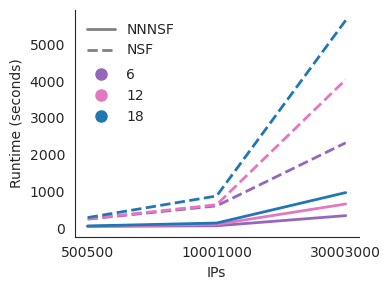

In [171]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
custom_colors = ['tab:purple', 'tab:pink', 'tab:blue']

# Prepare the data for both nnnsf and nsf runtimes
nnnsf_runtime_long = nnnsf_runtimes_df.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nsf_runtime_long = nsf_runtimes_df.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')

# Add 'Number of Neighbors' as a column
nnnsf_runtime_long['Factors'] = nnnsf_runtime_long['index']
nsf_runtime_long['Factors'] = nsf_runtime_long['index']

# Plot nnnsf on the left subplot without legend for 'Number of Neighbors'
#sns.lineplot(nnnsf_runtime_long, x='IPs', y="Runtime", hue='Number of Neighbors', linewidth=4, palette='Set2', alpha=0.6, zorder=0, ax=ax[0], legend=False)
sns.lineplot(nsf_runtime_long*2, x='IPs', y="Runtime", hue='Factors', linewidth=2, zorder=0, ax=ax, palette=custom_colors, linestyle='--')

# Plot nnnsf on the right subplot with the legend for 'Number of Neighbors'
sns.lineplot(nnnsf_runtime_long*2, x='IPs', y="Runtime", hue='Factors', linewidth=2, zorder=0, ax=ax, palette=custom_colors)

unique_factors = nnnsf_runtime_long['Factors'].unique()
factors_legend = [
    Line2D([0], [0], color=custom_colors[i], marker='o', linestyle='None', markersize=8, label=str(factor))
    for i, factor in enumerate(unique_factors)
]

custom_legend = [
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='NNNSF'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='NSF')
]


# Add the Factors legend with dots as markers
factors_legend_handle = ax.legend(handles=factors_legend, loc="upper left", bbox_to_anchor=(0, 0.8), frameon=False, fontsize=10, title_fontsize=10)
ax.add_artist(factors_legend_handle)  # Add this legend first

# Add the custom line style legend for NSF and NNNSF
ax.legend(handles=custom_legend, loc="upper left", frameon=False, fontsize=10, title_fontsize=10)

# Set labels for both plots
ax.set_ylabel("Runtime (seconds)", size=10)
ax.set_xlabel("IPs", size=10)
#ax[1].set_ylabel("", size=10)
#ax[1].set_xlabel("IPs", size=10)
#ax[0].set_title("NSF")
#ax[1].set_title("NNNSF")
sns.despine()
# Show the plot
plt.tight_layout()
fig.savefig(f"{SPATH}/merfish_runntimes_nnnsfk=4_nsf.png")
plt.show()

In [253]:
nnnsf_runtimes_df_k2 = pd.read_csv(path.join(SPATH, 'merfish_nnnsf_runtimes_k=2.csv'), index_col=0)
nnnsf_runtimes_df_k4 = pd.read_csv(path.join(SPATH, 'merfish_nnnsf_runtimes_k=4.csv'), index_col=0)
nnnsf_runtimes_df_k8 = pd.read_csv(path.join(SPATH, 'merfish_nnnsf_runtimes_k=8.csv'), index_col=0)

In [192]:
nnnsf_runtime_long_2

index   IPs     Runtime  Factors
0      6   500   24.035893        6
1     12   500   23.510236       12
2     18   500   25.818859       18
3      6  1000   26.391089        6
4     12  1000   36.044983       12
5     18  1000   47.006732       18
6      6  3000   96.959672        6
7     12  3000  177.547799       12
8     18  3000  257.507563       18

/tmp/ipykernel_874604/1932212519.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([500, 1000, 3000])


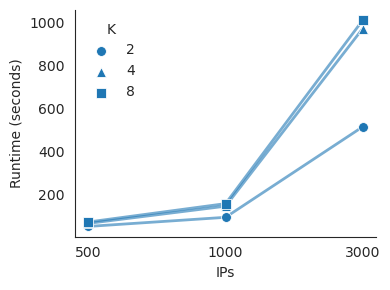

In [302]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)

nnnsf_runtime_long_2 = nnnsf_runtimes_df_k2.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nnnsf_runtime_long_4 = nnnsf_runtimes_df_k4.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
nnnsf_runtime_long_8 = nnnsf_runtimes_df_k8.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')
#nsf_runtime_long = nsf_runtimes_df.reset_index().melt(id_vars='index', var_name='IPs', value_name='Runtime')

# Add 'Number of Neighbors' as a column
nnnsf_runtime_long_2['Factors'] = nnnsf_runtime_long_2['index']
nnnsf_runtime_long_4['Factors'] = nnnsf_runtime_long_4['index']
nnnsf_runtime_long_8['Factors'] = nnnsf_runtime_long_8['index']
sns.scatterplot(nnnsf_runtime_long_2[nnnsf_runtime_long_2['Factors'] == 18]*2, x='IPs', y="Runtime", label="2", color='tab:blue', marker='o', zorder=1, s=50)
sns.lineplot(nnnsf_runtime_long_2[nnnsf_runtime_long_2['Factors'] == 18]*2, x='IPs', y="Runtime", linewidth=2, alpha=0.6, color='tab:blue', linestyle='-', zorder=0)
sns.scatterplot(nnnsf_runtime_long_4[nnnsf_runtime_long_4['Factors'] == 18]*2, x='IPs', y="Runtime", label="4", color='tab:blue', marker='^', s=50)
sns.lineplot(nnnsf_runtime_long_4[nnnsf_runtime_long_4['Factors'] == 18]*2, x='IPs', y="Runtime", linewidth=2, alpha=0.6, color='tab:blue', linestyle='-', zorder=0)
sns.scatterplot(nnnsf_runtime_long_8[nnnsf_runtime_long_8['Factors'] == 18]*2, x='IPs', y="Runtime", label="8", color='tab:blue', marker='s', s=50)
sns.lineplot(nnnsf_runtime_long_8[nnnsf_runtime_long_8['Factors'] == 18]*2, x='IPs', y="Runtime", linewidth=2, alpha=0.6, color='tab:blue', linestyle='-', zorder=0)
ax.legend(frameon=False, title="K")
ax.set_ylabel("Runtime (seconds)")
ax.set_xticklabels([500, 1000, 3000])
sns.despine()
plt.tight_layout()
fig.savefig(f"{SPATH}/merfish_runntimes_nnnsfl=18_k.png")

### Metrics - Old

In [135]:
ad = sc.read_h5ad(merpath)
ad = ad[(ad.obs['percent.mt'] < 5), :]
min_genes_per_cell = 500
ad = ad[ad.obs['nFeature_RNA'] >= min_genes_per_cell, :]
min_value = np.min(ad.X)
if min_value < 0:
    ad.X += np.abs(min_value)
ad.var_names_make_unique()
labels = ad.obs.Age.unique()
ad.obs['Age_cat'] = ad.obs['Age'].astype('category')
ad = ad[~ad.obs['Age'].isin([20.8, 22.6, 3.33])]
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
Y = np.array(ad.X, dtype=int).T
X = ad.obsm['X_harmony']
X = X.astype('float32')
Y = Y.astype('float32')
X = rescale_spatial_coords(X)
ad.uns['counts'] = ad.X.copy()
    
ad.var['deviance_poisson'] = deviancePoisson(ad.uns["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
    
X = np.array(ad.obs['Age'])[:, None]
X = torch.tensor(X, dtype=torch.float)
Y = np.log(np.exp(Y) + 1e-2)  # correction

/tmp/ipykernel_874604/3194852472.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ad.uns['counts'] = ad.X.copy()


In [ ]:
import warnings
from sklearn.metrics import explained_variance_score
from scipy.stats import norm  # Assuming Gaussian log-likelihood
from scipy.special import gammaln
from scipy.spatial.distance import jensenshannon

def explained_variance(y_true, y_pred):
    return explained_variance_score(y_pred, y_true)

# Define Poisson log-likelihood function
def poisson_log_likelihood(y_true, y_pred):
    # y_pred is the expected mean under the Poisson assumption
    # Add a small epsilon to avoid log(0) if necessary
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, None)  # Ensure y_pred is positive
    return np.sum(y_true * np.log(y_pred) - y_pred - gammaln(y_true + 1))

# Define Jensen-Shannon Divergence function
def jensen_shannon_divergence(y_true, y_pred, epsilon=1e-10):
    # Ensure y_true and y_pred are arrays with probabilities for each distribution
    y_true = np.clip(y_true, epsilon, None)
    y_pred = np.clip(y_pred, epsilon, None)
    
    # Normalize each row (distribution) to sum to 1
    y_true /= y_true.sum(axis=1, keepdims=True)
    y_pred /= y_pred.sum(axis=1, keepdims=True)
    
    # Compute JS Divergence for each distribution (row) and take the mean
    js_divergences = [jensenshannon(y_true[i], y_pred[i]) ** 2 for i in range(y_true.shape[0])]
    return np.mean(js_divergences)

warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
X = torch.tensor(X)
Y = np.array(Y)
L = [6, 12, 18]
M = [500, 1000, 2000, 3000]
K = [2, 4, 8]
# Initialize dictionaries to store data
rmse_dict = {}
poi_dict = {}
js_dict = {}

for k in K:
    rmse_dict = {}
    poi_dict = {}
    js_dict = {}
    for l in L:
        inducing_point_rmse = []
        inducing_point_poi = []
        inducing_point_js = []
        for m in M:
            rmse_values = []
            poi_values = []
            js_values = []
            
            # Define parameters for each experiment
            dicts = {
                'L': l, 
                'M': m, 
                'K': k,
                'sigma': 0.3, 
                'lengthscale': 0.02, 
                'jtr': 0.1,
                'batch_size': 64,
                'lr': 0.01,
                'rs': 256,
                'lkzz_build': 1,
                'model': 'VNNGP',
                'L1_jitter': 1e-1
            }
    
            # Load NMF factors and loadings
            nmf_save_path = path.join(SPATH, 'nmf/3000')
            factors_file = f"nmf_factors_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33)_new.npy"
            loadings_file = f"nmf_loadings_iter=1000_rs=256_L={l}.npy"
            factors = np.load(path.join(nmf_save_path, factors_file))
            loadings = np.load(path.join(nmf_save_path, loadings_file))
            
            # Build model
            model = putil.build_model(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
            modelpath = path.join(SPATH, 'nnnsf')
    
            # Run evaluations for different initializations
            for i in range(3):  # Assuming 3 different processing paths
                filepath = f"3000_new_processing_{i}/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr={dicts['lr']}_jtr={dicts['jtr']}_ls={dicts['lengthscale']}_sigma={dicts['sigma']}_bs=128_NMFinit_state_dict.pth"
                dictpath = path.join(modelpath, filepath)
                model.load_state_dict(torch.load(dictpath))
    
                # Evaluate model
                rmse = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=root_mean_squared_error, kwargs=dicts)
                poi = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=mean_poisson_deviance, kwargs=dicts)
                js = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=jensen_shannon_divergence, kwargs=dicts)
                
                # Append to lists for calculating mean and std
                rmse_values.append(rmse)
                poi_values.append(poi)
                js_values.append(js)
            
            # Calculate mean and standard deviation
            mean_rmse = np.mean(rmse_values)
            std_rmse = np.std(rmse_values)
            mean_poi = np.mean(poi_values)
            std_poi = np.std(poi_values)
            mean_js = np.mean(js_values)
            std_js = np.std(js_values)
            
            inducing_point_rmse.append((mean_rmse, std_rmse))
            inducing_point_poi.append((mean_poi, std_poi))
            inducing_point_js.append((mean_js, std_js))
            
            print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, RMSE: {mean_rmse} ± {std_rmse}")
            print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, POI: {mean_poi} ± {std_poi}")
            print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, JS: {mean_js} ± {std_js}")
        rmse_dict[str(l)] = inducing_point_rmse
        poi_dict[str(l)] = inducing_point_poi
        js_dict[str(l)] = inducing_point_js
        print(f"DONE with factor {l}")
    rmse_df = pd.DataFrame(rmse_dict)
    rmse_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_rmse_error.npy'))
    poi_df = pd.DataFrame(poi_dict)
    poi_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_poi_error.npy'))
    js_df = pd.DataFrame(js_dict)
    js_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_js_error.npy'))
    overall_rmse_dict[k] = rmse_dict.copy()
    overall_poi_dict[k] = poi_dict.copy()
    overall_js_dict[k] = js_dict.copy()

In [285]:
# 2 neighbors
rmse_df = pd.DataFrame(rmse_dict)
rmse_df.to_csv(path.join(nnnsf_path, 'merfish_k=2_rmse_error.npy'))
poi_df = pd.DataFrame(poi_dict)
poi_df.to_csv(path.join(nnnsf_path, 'merfish_k=2_poi_error.npy'))
js_df = pd.DataFrame(js_dict)
js_df.to_csv(path.join(nnnsf_path, 'merfish_k=2_js_error.npy'))

In [152]:
# 4 neighbors
rmse_df = pd.DataFrame(rmse_dict)
rmse_df.to_csv(path.join(nnnsf_path, 'merfish_k=4_rmse_error.npy'))
poi_df = pd.DataFrame(poi_dict)
poi_df.to_csv(path.join(nnnsf_path, 'merfish_k=4_poi_error.npy'))
js_df = pd.DataFrame(js_dict)
js_df.to_csv(path.join(nnnsf_path, 'merfish_k=4_js_error.npy'))

In [150]:
# 8 neighbors
rmse_df = pd.DataFrame(rmse_dict)
rmse_df.to_csv(path.join(nnnsf_path, 'merfish_k=8_rmse_error.npy'))
poi_df = pd.DataFrame(poi_dict)
poi_df.to_csv(path.join(nnnsf_path, 'merfish_k=8_poi_error.npy'))
js_df = pd.DataFrame(js_dict)
js_df.to_csv(path.join(nnnsf_path, 'merfish_k=8_js_error.npy'))

In [149]:
nnnsf_path

'/engelhardt/home/pshrestha/vnngp/results/merfish/nnnsf'

In [265]:
overall_poi_dict

{8: {'6': [(0.20230968, 0.0011684153),
   (0.20275648, 0.0009000946),
   (0.2016017, 0.0005206006),
   (0.20455372, 0.0007489876)],
  '12': [(0.1772642, 0.0004638859),
   (0.17503686, 0.00059037335),
   (0.17790247, 0.0008754668),
   (0.18006273, 0.00070037175)],
  '18': [(0.16987564, 0.0009579492),
   (0.17102055, 0.0036197177),
   (0.17055714, 0.00030158658),
   (0.17247485, 0.0006163503)]},
 2: {'6': [(0.20684619, 0.0014640029),
   (0.21402507, 0.00039491773),
   (0.22650282, 0.000976913),
   (0.23672394, 0.00044577452)],
  '12': [(0.18641031, 0.00035155995),
   (0.19399558, 0.0008998266),
   (0.20858847, 0.0008360926),
   (0.22016025, 0.0007631548)],
  '18': [(0.18197261, 0.0003074656),
   (0.19108939, 0.00068076025),
   (0.20662189, 0.00015186654),
   (0.21634461, 0.0006493649)]},
 4: {'6': [(0.20315598, 0.00016562581),
   (0.20602137, 0.00016881624),
   (0.20925151, 0.00095841143),
   (0.21381378, 0.00049200165)],
  '12': [(0.17761375, 0.0005216541),
   (0.18078662, 0.00039139175

(0.20684619, 0.21402507, 0.22650282, 0.23672394)
(0.18641031, 0.19399558, 0.20858847, 0.22016025)
(0.18197261, 0.19108939, 0.20662189, 0.21634461)


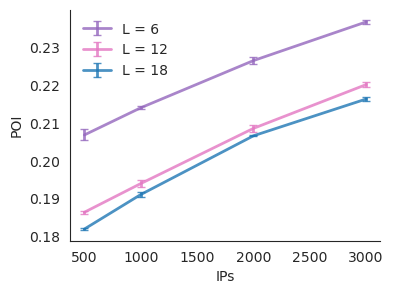

In [286]:
# Plot RMSE with error bars
custom_colors = ['tab:purple', 'tab:pink', 'tab:blue']
poi_dict = overall_poi_dict[2]

fig, ax = plt.subplots(figsize=(4, 3)) 
for i, (l, color) in enumerate(zip(poi_dict.keys(), custom_colors)):
    means, stds = zip(*poi_dict[l])
    print(means)
    plt.errorbar(M, means, yerr=stds, label=f"L = {l}", capsize=3, color=color, linewidth=2, alpha=0.8)
plt.xlabel("IPs")
plt.ylabel("POI")
plt.legend(frameon=False)
sns.despine(fig=fig)
plt.show()

(0.20315598, 0.20602137, 0.20925151, 0.21381378)
(0.17761375, 0.18078662, 0.18687709, 0.19197345)
(0.17243963, 0.17437182, 0.17999893, 0.18465799)


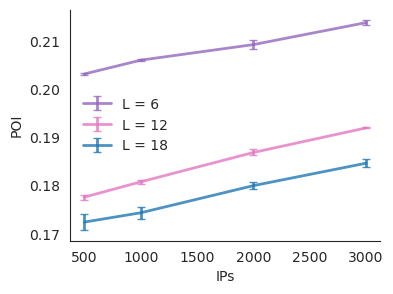

In [287]:
# Plot RMSE with error bars
custom_colors = ['tab:purple', 'tab:pink', 'tab:blue']
poi_dict = overall_poi_dict[4]

fig, ax = plt.subplots(figsize=(4, 3)) 
for i, (l, color) in enumerate(zip(poi_dict.keys(), custom_colors)):
    means, stds = zip(*poi_dict[l])
    print(means)
    plt.errorbar(M, means, yerr=stds, label=f"L = {l}", capsize=3, color=color, linewidth=2, alpha=0.8)
plt.xlabel("IPs")
plt.ylabel("POI")
plt.legend(frameon=False)
sns.despine(fig=fig)
plt.show()

(0.20230968, 0.20275648, 0.2016017, 0.20455372)
(0.1772642, 0.17503686, 0.17790247, 0.18006273)
(0.16987564, 0.17102055, 0.17055714, 0.17247485)


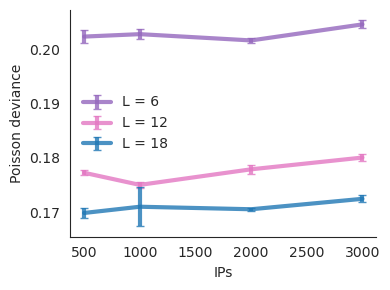

In [357]:
custom_colors = ['tab:purple', 'tab:pink', 'tab:blue']
poi_dict = overall_poi_dict[8]

fig, ax = plt.subplots(figsize=(4, 3)) 
for i, (l, color) in enumerate(zip(poi_dict.keys(), custom_colors)):
    means, stds = zip(*poi_dict[l])
    print(means)
    plt.errorbar(M, means, yerr=stds, label=f"L = {l}", capsize=3, color=color, linewidth=3, alpha=0.8)
plt.xlabel("IPs")
plt.ylabel("Poisson deviance")
plt.legend(frameon=False)
sns.despine(fig=fig)
plt.tight_layout()
plt.savefig(path.join(SPATH, 'merfish_factors_k=8_poisson_deviance.png'))
plt.show()

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549)]


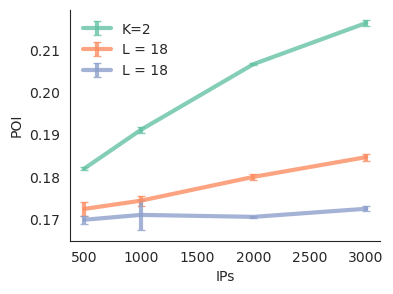

In [307]:
two_dict = overall_poi_dict[2]
four_dict = overall_poi_dict[4]
eight_dict = overall_poi_dict[8]

fig, ax = plt.subplots(figsize=(4, 3)) 
means, stds = zip(*two_dict['18'])

colors = sns.color_palette('Set2', n_colors=3)
print(colors)

plt.errorbar(M, means, yerr=stds, capsize=3, label = 'K=2', color=colors[0], linewidth=3, alpha=0.8)

means, stds = zip(*four_dict['18'])
plt.errorbar(M, means, yerr=stds, label=f"L = {l}", capsize=3, color=colors[1], linewidth=3, alpha=0.8)


means, stds = zip(*eight_dict['18'])
plt.errorbar(M, means, yerr=stds, label=f"L = {l}", capsize=3, color=colors[2], linewidth=3, alpha=0.8)

plt.xlabel("IPs")
plt.ylabel("POI")
plt.legend(frameon=False)
sns.despine(fig=fig)
plt.show()

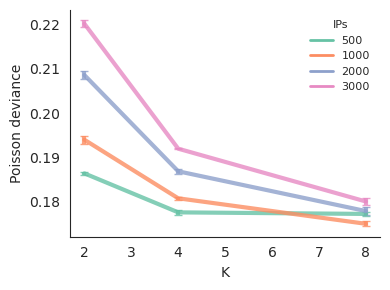

In [362]:
from matplotlib.lines import Line2D

# Define variables
two_dict = overall_poi_dict[2]
four_dict = overall_poi_dict[4]
eight_dict = overall_poi_dict[8]

K_values = [2, 4, 8]  # K on x-axis
M_values = [500, 1000, 2000, 3000]  # IPs (inducing points)
colors = sns.color_palette('Set2', n_colors=len(M_values))  # One color per M

# Prepare the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Plot for each IP (M)
for i, m in enumerate(M_values):
    # Extract means and stds for each K
    means = [two_dict['12'][i][0], four_dict['12'][i][0], eight_dict['12'][i][0]]
    stds = [two_dict['12'][i][1], four_dict['12'][i][1], eight_dict['12'][i][1]]
    
    # Plot line for this M
    plt.errorbar(
        K_values, means, yerr=stds, capsize=3, label=f"{m}",
        color=colors[i], linewidth=3, alpha=0.8
    )

# Create a custom legend with only lines (no error bars)
legend_elements = [
    Line2D([0], [0], color=colors[i], linewidth=2, label=f"{m}")
    for i, m in enumerate(M_values)
]
plt.legend(handles=legend_elements, frameon=False, title="IPs", fontsize=8, title_fontsize=8)

# Add labels, legend, and formatting
plt.xlabel("K")
plt.ylabel("Poisson deviance")
sns.despine(fig=fig)
plt.tight_layout()
plt.savefig(path.join(SPATH, 'merfish_ips_k_l=12_poisson_deviance.png'))
plt.show()

### Metrics - New

In [369]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
X = torch.tensor(X)
Y = np.array(Y)
L = [6, 12, 18]
M = [500, 1000, 2000, 3000]
K = [2, 4, 8]
# Initialize dictionaries to store data
overall_rmse_dict = {}
overall_poi_dict = {}
overall_js_dict = {}

for k in K:
    rmse_dict = {}
    poi_dict = {}
    js_dict = {}
    for l in L:
        inducing_point_rmse = []
        inducing_point_poi = []
        inducing_point_js = []
        for m in M:
            rmse_values = []
            poi_values = []
            js_values = []
            
            # Define parameters for each experiment
            dicts = {
                'L': l, 
                'M': m, 
                'K': k,
                'sigma': 0.3, 
                'lengthscale': 0.02, 
                'jtr': 0.1,
                'batch_size': 128,
                'lr': 0.01,
                'rs': 256,
                'lkzz_build': 1,
                'model': 'VNNGP',
                'L1_jitter': 1e-1
            }
    
            # Load NMF factors and loadings
            nmf_save_path = path.join(SPATH, 'nmf/3000')
            factors_file = f"nmf_factors_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33)_new.npy"
            loadings_file = f"nmf_loadings_iter=1000_rs=256_L={l}.npy"
            factors = np.load(path.join(nmf_save_path, factors_file))
            loadings = np.load(path.join(nmf_save_path, loadings_file))
            
            # Build model
            model = putil.build_model(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
            modelpath = path.join(SPATH, 'nnnsf')
    
  
            filepath = f"3000_d1_no_spatial_standardization_0/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr={dicts['lr']}_jtr={dicts['jtr']}_ls={dicts['lengthscale']}_sigma={dicts['sigma']}_bs=128_NMFinit_state_dict.pth"
            dictpath = path.join(modelpath, filepath)
            if not os.path.exists(dictpath):
                rmse_values.append(None)
                poi_values.append(None)
                js_values.append(None)
                continue
            model.load_state_dict(torch.load(dictpath))
    
            # Evaluate model
            rmse = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=root_mean_squared_error, kwargs=dicts)
            poi = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=mean_poisson_deviance, kwargs=dicts)
            js = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=jensen_shannon_divergence, kwargs=dicts)
                
            # Append to lists for calculating mean and std
            rmse_values.append(rmse)
            poi_values.append(poi)
            js_values.append(js)
            
            # Calculate mean and standard deviation
            mean_rmse = np.mean(rmse_values)
            mean_poi = np.mean(poi_values)
            mean_js = np.mean(js_values)
            
            inducing_point_rmse.append(mean_rmse)
            inducing_point_poi.append(mean_poi)
            inducing_point_js.append(mean_js)
            
            print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, RMSE: {mean_rmse}")
            print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, POI: {mean_poi}")
            print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, JS: {mean_js}")
        rmse_dict[str(l)] = inducing_point_rmse
        poi_dict[str(l)] = inducing_point_poi
        js_dict[str(l)] = inducing_point_js
        print(f"DONE with factor {l}")
    #rmse_df = pd.DataFrame(rmse_dict)
    #rmse_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_rmse_error.npy'))
    #poi_df = pd.DataFrame(poi_dict)
    #poi_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_poi_error.npy'))
    #js_df = pd.DataFrame(js_dict)
    #js_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_js_error.npy'))
    overall_rmse_dict[k] = rmse_dict.copy()
    overall_poi_dict[k] = poi_dict.copy()
    overall_js_dict[k] = js_dict.copy()

With 6 factors, 2 neighbors and 500 IPs, RMSE: 2.1647894382476807
With 6 factors, 2 neighbors and 500 IPs, POI: 1.1267017126083374
With 6 factors, 2 neighbors and 500 IPs, JS: 0.012794782983139158
With 6 factors, 2 neighbors and 1000 IPs, RMSE: 3.0278711318969727
With 6 factors, 2 neighbors and 1000 IPs, POI: 3.473276376724243
With 6 factors, 2 neighbors and 1000 IPs, JS: 0.03705419992593428
With 6 factors, 2 neighbors and 2000 IPs, RMSE: 3.5524704456329346
With 6 factors, 2 neighbors and 2000 IPs, POI: 5.122946262359619
With 6 factors, 2 neighbors and 2000 IPs, JS: 0.05312901536623637
With 6 factors, 2 neighbors and 3000 IPs, RMSE: 3.0805084705352783
With 6 factors, 2 neighbors and 3000 IPs, POI: 3.7231194972991943
With 6 factors, 2 neighbors and 3000 IPs, JS: 0.0396131295679758
DONE with factor 6
With 12 factors, 2 neighbors and 500 IPs, RMSE: 2.473036766052246
With 12 factors, 2 neighbors and 500 IPs, POI: 1.6625633239746094
With 12 factors, 2 neighbors and 500 IPs, JS: 0.0177432664

In [375]:
two_df = pd.DataFrame(overall_rmse_dict[2])
two_df.to_csv(path.join(SPATH, 'merfish_rmse_k=2.csv'))
four_df = pd.DataFrame(overall_rmse_dict[4])
four_df.to_csv(path.join(SPATH, 'merfish_rmse_k=4.csv'))
eight_df = pd.DataFrame(overall_rmse_dict[8])
eight_df.to_csv(path.join(SPATH, 'merfish_rmse_k=8.csv'))

[1.1253151, 1.1281608, 1.1282002]
[3.472739, 1.8452045, 2.2028031]
[5.1255713, 2.8656535, 2.2151375]


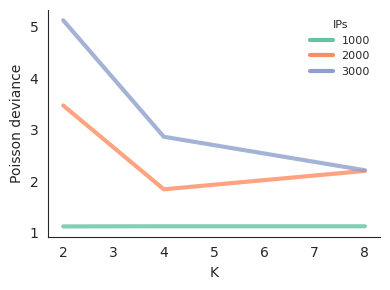

In [326]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Define variables
two_dict = overall_poi_dict[2]
four_dict = overall_poi_dict[4]
eight_dict = overall_poi_dict[8]

K_values = [2, 4, 8]  # K on x-axis
M_values = [1000, 2000, 3000]  # IPs (inducing points)
colors = sns.color_palette('Set2', n_colors=len(M_values))  # One color per M

# Prepare the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Plot for each IP (M)
for i, m in enumerate(M_values):
    # Extract means for each K
    means = [
        two_dict['6'][i], 
        four_dict['6'][i], 
        eight_dict['6'][i]
    ]
    print(means)
    
    # Plot line for this M
    ax.plot(
        K_values, means, label=f"{m}",
        color=colors[i], linewidth=3, alpha=0.8
    )

# Create a custom legend with only lines (no error bars)
legend_elements = [
    Line2D([0], [0], color=colors[i], linewidth=3, label=f"{m}")
    for i, m in enumerate(M_values)
]
ax.legend(handles=legend_elements, frameon=False, title="IPs", fontsize=8, title_fontsize=8)

# Add labels, legend, and formatting
ax.set_xlabel("K")
ax.set_ylabel("Poisson deviance")
sns.despine(fig=fig)
plt.tight_layout()

# Save or display the plot
plt.savefig(path.join(SPATH, 'merfish_ips_k_l=6_poisson_deviance.png'))
plt.show()


[2.1655316, 2.1718717, 2.1789384]
[3.030874, 2.3953853, 2.4912908]
[3.5548396, 2.7863905, 2.5393734]


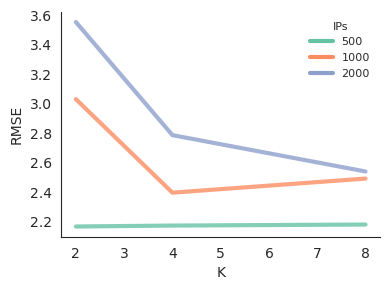

In [324]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Define variables
two_dict = overall_rmse_dict[2]
four_dict = overall_rmse_dict[4]
eight_dict = overall_rmse_dict[8]

K_values = [2, 4, 8]  # K on x-axis
M_values = [500,1000, 2000]  # IPs (inducing points)
colors = sns.color_palette('Set2', n_colors=len(M_values))  # One color per M

# Prepare the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Plot for each IP (M)
for i, m in enumerate(M_values):
    # Extract means for each K
    means = [
        two_dict['6'][i], 
        four_dict['6'][i], 
        eight_dict['6'][i]
    ]
    print(means)
    
    # Plot line for this M
    ax.plot(
        K_values, means, label=f"{m}",
        color=colors[i], linewidth=3, alpha=0.8
    )

# Create a custom legend with only lines (no error bars)
legend_elements = [
    Line2D([0], [0], color=colors[i], linewidth=3, label=f"{m}")
    for i, m in enumerate(M_values)
]
ax.legend(handles=legend_elements, frameon=False, title="IPs", fontsize=8, title_fontsize=8)

# Add labels, legend, and formatting
ax.set_xlabel("K")
ax.set_ylabel("RMSE")
sns.despine(fig=fig)
plt.tight_layout()

# Save or display the plot
plt.savefig(path.join(SPATH, 'merfish_ips_k_l=6_rmse.png'))
plt.show()


[0.012784003301523626, 0.012856515140272678, 0.01293487045634538]
[0.037050755229468144, 0.020055210255396864, 0.023359893325716256]
[0.05315611091007789, 0.03081181764851014, 0.02423582086029152]


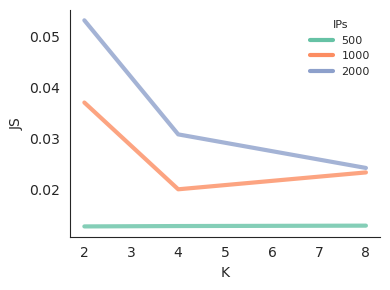

In [325]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Define variables
two_dict = overall_js_dict[2]
four_dict = overall_js_dict[4]
eight_dict = overall_js_dict[8]

K_values = [2, 4, 8]  # K on x-axis
M_values = [500, 1000, 2000]  # IPs (inducing points)
colors = sns.color_palette('Set2', n_colors=len(M_values))  # One color per M

# Prepare the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Plot for each IP (M)
for i, m in enumerate(M_values):
    # Extract means for each K
    means = [
        two_dict['6'][i], 
        four_dict['6'][i], 
        eight_dict['6'][i]
    ]
    print(means)
    
    # Plot line for this M
    ax.plot(
        K_values, means, label=f"{m}",
        color=colors[i], linewidth=3, alpha=0.8
    )

# Create a custom legend with only lines (no error bars)
legend_elements = [
    Line2D([0], [0], color=colors[i], linewidth=3, label=f"{m}")
    for i, m in enumerate(M_values)
]
ax.legend(handles=legend_elements, frameon=False, title="IPs", fontsize=8, title_fontsize=8)

# Add labels, legend, and formatting
ax.set_xlabel("K")
ax.set_ylabel("JS")
sns.despine(fig=fig)
plt.tight_layout()

# Save or display the plot
plt.savefig(path.join(SPATH, 'merfish_ips_k_l=6_js_deviance.png'))
plt.show()


[1.1281608, 1.8452045, 2.8656535, 4.2529435]
[500, 1000, 2000, 3000]
[1.6635027, 1.663168, 2.685562, 4.319539]
[500, 1000, 2000, 3000]
[2.039516, 2.423281, 3.1398075, 3.454359]
[500, 1000, 2000, 3000]


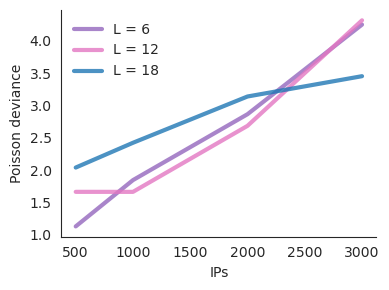

In [322]:
custom_colors = ['tab:purple', 'tab:pink', 'tab:blue']
poi_dict = overall_poi_dict[4]

fig, ax = plt.subplots(figsize=(4, 3)) 
for i, (l, color) in enumerate(zip(poi_dict.keys(), custom_colors)):
    means = poi_dict[l]
    print(means)
    print(M)
    ax.plot(M, means, label=f"L = {l}", color=color, linewidth=3, alpha=0.8)
plt.xlabel("IPs")
plt.ylabel("Poisson deviance")
plt.legend(frameon=False)
sns.despine(fig=fig)
plt.tight_layout()
#plt.savefig(path.join(SPATH, 'merfish_factors_k=8_poisson_deviance.png'))
plt.show()

In [329]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()



merpath = path.join(dpth, "merfish.h5ad")
ad = sc.read_h5ad(merpath)
min_value = np.min(ad.X)
if min_value < 0:
    ad.X += np.abs(min_value)
ad.var_names_make_unique()
labels = ad.obs.Age.unique()
ad.obs['Age_cat'] = ad.obs['Age'].astype('category')
Y_sums = np.array(np.sum(ad.X > 0, axis=0))[0]
Y = np.array(ad.X, dtype=int).T
X = ad.obsm['X_harmony']
X = X.astype('float32')
Y = Y.astype('float32')
X = rescale_spatial_coords(X)
ad.uns['counts'] = ad.X.copy()
    
ad.var['deviance_poisson'] = deviancePoisson(ad.uns["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
    
#Y = np.array(ad.X)
X = np.array(ad.obs['Age'])[:, None]
    
X = torch.tensor(X, dtype=torch.float)
Y = np.log(np.exp(Y) + 1e-2)  # correction

X = torch.tensor(X)
Y = np.array(Y)

In [354]:
L = [6, 12, 18]
M = [500, 1000, 2000, 3000]

# Initialize dictionaries to store data
overall_rmse_dict = {}
overall_poi_dict = {}
overall_js_dict = {}

rmse_dict = {}
poi_dict = {}
js_dict = {}
for l in L:
    inducing_point_rmse = []
    inducing_point_poi = []
    inducing_point_js = []
    for m in M:
        rmse_values = []
        poi_values = []
        js_values = []
            
        # Define parameters for each experiment
        dicts = {
                'L': l, 
                'M': m, 
                'sigma': 0.02, 
                'lengthscale': 0.002, 
                'jtr': 0.1,
                'batch_size': 128,
                'lr': 0.01,
                'rs': 256,
                'lkzz_build': 1,
                'model': 'SVGP',
                'L1_jitter': 1e-1
        }
    
        # Load NMF factors and loadings
        nmf_save_path = path.join(SPATH, 'nmf/3000')
        factors_file = f"nmf_factors_iter=1000_rs=256_L={l}.npy"
        loadings_file = f"nmf_loadings_iter=1000_rs=256_L={l}.npy"
        factors = np.load(path.join(nmf_save_path, factors_file))
        loadings = np.load(path.join(nmf_save_path, loadings_file))
            
        # Build model
        model = putil.build_model(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
        modelpath = path.join(SPATH, 'nsf')
    
  
        filepath = f"3000/SVGP_M={dicts['M']}_L={dicts['L']}_lr={dicts['lr']}_jtr={dicts['jtr']}_ls={dicts['lengthscale']}_sigma={dicts['sigma']}_bs=128_NMFinit_state_dict.pth"
        dictpath = path.join(modelpath, filepath)
        #print(dictpath)
        if not os.path.exists(dictpath):
            rmse_values.append(None)
            poi_values.append(None)
            js_values.append(None)
            continue
        model.load_state_dict(torch.load(dictpath))
    
        # Evaluate model
        rmse = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=root_mean_squared_error, kwargs=dicts)
        poi = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=mean_poisson_deviance, kwargs=dicts)
        js = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=jensen_shannon_divergence, kwargs=dicts)
                
        # Append to lists for calculating mean and std
        rmse_values.append(rmse)
        poi_values.append(poi)
        js_values.append(js)
            
        # Calculate mean and standard deviation
        mean_rmse = np.mean(rmse_values)
        mean_poi = np.mean(poi_values)
        mean_js = np.mean(js_values)
            
        inducing_point_rmse.append(mean_rmse)
        inducing_point_poi.append(mean_poi)
        inducing_point_js.append(mean_js)
            
        print(f"With {l} factors and {m} IPs, RMSE: {mean_rmse}")
        print(f"With {l} factors and {m} IPs, POI: {mean_poi}")
        print(f"With {l} factors and {m} IPs, JS: {mean_js}")
    rmse_dict[str(l)] = inducing_point_rmse
    poi_dict[str(l)] = inducing_point_poi
    js_dict[str(l)] = inducing_point_js
    print(f"DONE with factor {l}")
    #rmse_df = pd.DataFrame(rmse_dict)
    #rmse_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_rmse_error.npy'))
    #poi_df = pd.DataFrame(poi_dict)
    #poi_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_poi_error.npy'))
    #js_df = pd.DataFrame(js_dict)
    #js_df.to_csv(path.join(nnnsf_path, f'merfish_k={k}_js_error.npy'))

With 6 factors and 500 IPs, RMSE: 2.0442981719970703
With 6 factors and 500 IPs, POI: 0.5261306166648865
With 6 factors and 500 IPs, JS: 0.006689883989592393
With 6 factors and 1000 IPs, RMSE: 2.2562315464019775
With 6 factors and 1000 IPs, POI: 0.5439915657043457
With 6 factors and 1000 IPs, JS: 0.005762478680815548
With 6 factors and 2000 IPs, RMSE: 2.858224391937256
With 6 factors and 2000 IPs, POI: 0.9813491106033325
With 6 factors and 2000 IPs, JS: 0.01277940745341281
With 6 factors and 3000 IPs, RMSE: 2.428734064102173
With 6 factors and 3000 IPs, POI: 0.6326855421066284
With 6 factors and 3000 IPs, JS: 0.007261308127703766
DONE with factor 6
With 12 factors and 500 IPs, RMSE: 2.4394030570983887
With 12 factors and 500 IPs, POI: 0.676543653011322
With 12 factors and 500 IPs, JS: 0.006557725785998628
With 12 factors and 1000 IPs, RMSE: 2.1430938243865967
With 12 factors and 1000 IPs, POI: 0.4812912344932556
With 12 factors and 1000 IPs, JS: 0.005119643801668038
With 12 factors and

In [355]:
rmse_dict['18'].append(None)

In [356]:
rmse_dict = pd.DataFrame(rmse_dict, index=['500', '1000', '2000', '3000'])

In [357]:
rmse_dict

6         12        18
500   2.044298   2.439403  2.245447
1000  2.256232   2.143094  1.815233
2000  2.858224   3.323457  2.115644
3000  2.428734  12.785251       NaN

In [358]:
rmse_dict.to_csv(path.join(nnnsf_path, f'merfish_nsf_rmse.csv'))

In [363]:
nnnsf_rmse_dict2 = pd.read_csv(path.join(SPATH, f'merfish_poi_k=2_rm.csv'))
nnnsf_rmse_dict4 = pd.read_csv(path.join(SPATH, f'merfish_poi_k=4_rm.csv'))
nnnsf_rmse_dict8 = pd.read_csv(path.join(SPATH, f'merfish_poi_k=8_rm.csv'))

In [383]:
rmse_dict

{'6': [2.1800795, 2.4906073, 2.5383465, 3.2849653],
 '12': [2.2674642, 2.3943813, 2.9784794, 4.656366],
 '18': [3.6620717, 3.6561182, 4.1676292, 67.47934]}

[2.1647894, 2.1693733, 2.1800795]
[3.0278711, 2.3952649, 2.4906073]
[3.5524704, 2.7846005, 2.5383465]


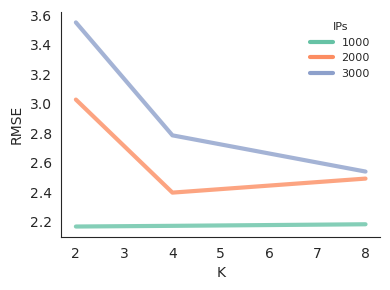

In [390]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Define variables
two_dict = two_df
four_dict = four_df
eight_dict = eight_df

K_values = [2, 4, 8]  # K on x-axis
M_values = [1000, 2000, 3000]  # IPs (inducing points)
colors = sns.color_palette('Set2', n_colors=len(M_values))  # One color per M

# Prepare the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Plot for each IP (M)
for i, m in enumerate(M_values):
    # Extract means for each K
    means = [
        two_dict['6'][i], 
        four_dict['6'][i], 
        eight_dict['6'][i], 
    ]
    print(means)
    
    # Plot line for this M
    ax.plot(
        K_values, means, label=f"{m}",
        color=colors[i], linewidth=3, alpha=0.8
    )

# Create a custom legend with only lines (no error bars)
legend_elements = [
    Line2D([0], [0], color=colors[i], linewidth=3, label=f"{m}")
    for i, m in enumerate(M_values)
]
ax.legend(handles=legend_elements, frameon=False, title="IPs", fontsize=8, title_fontsize=8)

# Add labels, legend, and formatting
ax.set_xlabel("K")
ax.set_ylabel("RMSE")
sns.despine(fig=fig)
plt.tight_layout()

# Save or display the plot
plt.savefig(path.join(SPATH, 'merfish_ips_k_l=6_rmse.png'))
plt.show()


In [ ]:
{'6': [2.1800795, 2.4906073, 2.5383465, 3.2849653],
 '12': [2.2674642, 2.3943813, 2.9784794, 4.656366],
 '18': [3.6620717, 3.6561182, 4.1676292, 67.47934]}

### Factors

In [6]:
merpath = path.join(dpth, "merfish.h5ad")
ad = sc.read_h5ad(merpath)
ad = ad[(ad.obs['percent.mt'] < 5), :]
min_genes_per_cell = 500
ad = ad[ad.obs['nFeature_RNA'] >= min_genes_per_cell, :]
min_value = np.min(ad.X)
if min_value < 0:
    ad.X += np.abs(min_value)
ad.var_names_make_unique()
labels = ad.obs.Age.unique()
ad.obs['Age_cat'] = ad.obs['Age'].astype('category')
ad = ad[~ad.obs['Age'].isin([20.8, 22.6, 3.33])]
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
Y = np.array(ad.X, dtype=int).T
X = ad.obsm['X_harmony']
X = X.astype('float32')
Y = Y.astype('float32')
#X = rescale_spatial_coords(X)
ad.uns['counts'] = ad.X.copy()
    
ad.var['deviance_poisson'] = deviancePoisson(ad.uns["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
    
X = np.array(ad.obs['Age'])[:, None]
X = torch.tensor(X, dtype=torch.float)
    
Y = np.log(np.exp(Y) + 1e-2)  # correction
#Y = Y.T

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

/tmp/ipykernel_2062945/2009058706.py:19: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ad.uns['counts'] = ad.X.copy()


X shape:  torch.Size([15582, 1])
Y shape:  (3000, 15582)


In [7]:
print(X.shape)
print(Y.shape)

torch.Size([15582, 1])
(3000, 15582)


In [8]:
def plot_umap_factors(loadings, ad):
    L = loadings.shape[1]
    size = 2
    fig, axes = plt.subplots(L // 6, 6, figsize=(size * 6, size * (L // 6)), tight_layout=True)

    # Find the global vmin and vmax across all factors
    #vmin = loadings.min().min()
    #vmax = loadings.max().max()

    for i in range(L):
        curr_ax = axes[i // 6, i % 6]
        sc.pl.embedding(
            ad,
            basis='umap_har',
            color=f'Factor {i+1}',
            ax=curr_ax,
            show=False,
            cmap='magma', 
        )

    plt.tight_layout()
    plt.show()
    return fig, axes

def plot_umap_factors_by_age(loadings, adata, dot_size=10):  # Added dot_size parameter
    L = loadings.shape[1]
    size = 2
    unique_ages = sorted(adata.obs['Age'].unique())  # Sort ages from youngest to oldest
    print(unique_ages)
    num_ages = len(unique_ages)
    vmin = loadings.min().min()
    vmax = loadings.max().max()

    
    # Create subplots
    fig, axes = plt.subplots(L, num_ages + 1, figsize=(size * (num_ages + 1), size * L), tight_layout=True)
    
    for i in range(L):
        # Plot the original UMAP for the factor
        sc.pl.embedding(adata, basis='umap_har', color=f'Factor {i+1}', ax=axes[i, 0], show=False, cmap='magma', size=dot_size, vmin=vmin, vmax=vmax)
        axes[i, 0].set_title(f'Factor {i+1} - Original')
        
        # Plot UMAPs for each age
        for j, age in enumerate(unique_ages):
            adata_age = adata[adata.obs['Age'] == age]
            sc.pl.embedding(
            adata_age,
            basis='umap_har',
            color=f'Factor {i+1}',
            ax=axes[i, j + 1],
            show=False,
            cmap='viridis',
            vmin=vmin,
            vmax=vmax,  # Set the global color limits
            size=dot_size
            )
            axes[i, j + 1].set_title(f'Age {age}')
    
    plt.tight_layout()
    plt.show()
    return fig

/tmp/ipykernel_2062945/1994762865.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['Celltype'] = ad.obs['Celltype'].astype('category')


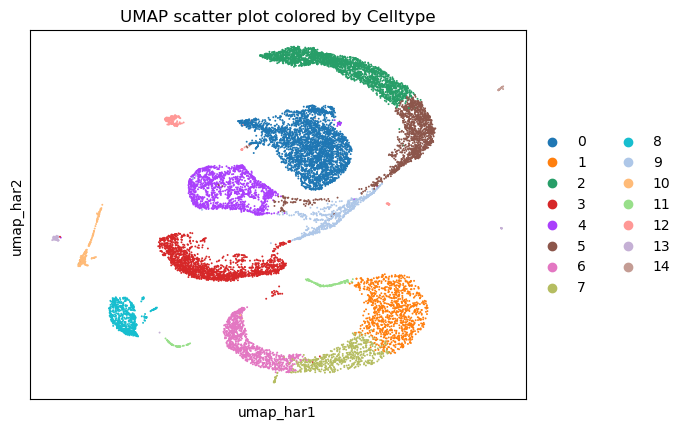

In [9]:
fig, ax = plt.subplots()
ad.obs['Celltype'] = ad.obs['Celltype'].astype('category')
sc.pl.embedding(ad, basis='umap_har', color='Celltype', title='UMAP scatter plot colored by Celltype', show=False, ax=ax)
plt.savefig(f'{SPATH}/umap_celltype.png', dpi=300, bbox_inches='tight')

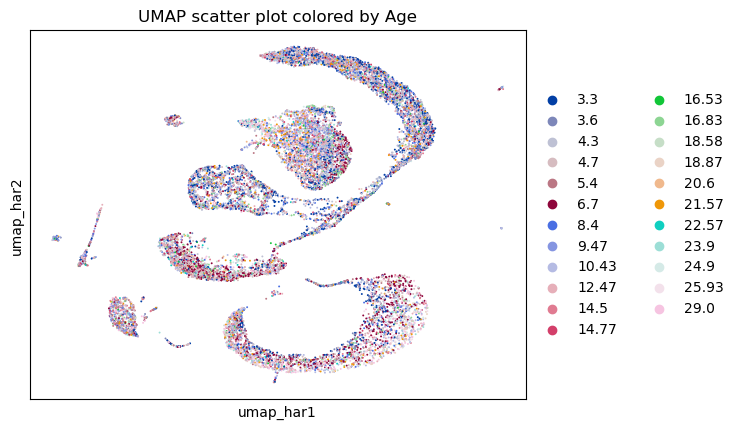

In [10]:
fig, ax = plt.subplots()
sc.pl.embedding(
    ad, 
    basis='umap_har', 
    color='Age_cat', 
    title='UMAP scatter plot colored by Age', 
    cmap='rocket', 
    ax=ax,
    show=False  # Prevent automatic display
)
plt.savefig(f'{SPATH}/umap_age.png', dpi=300, bbox_inches='tight')


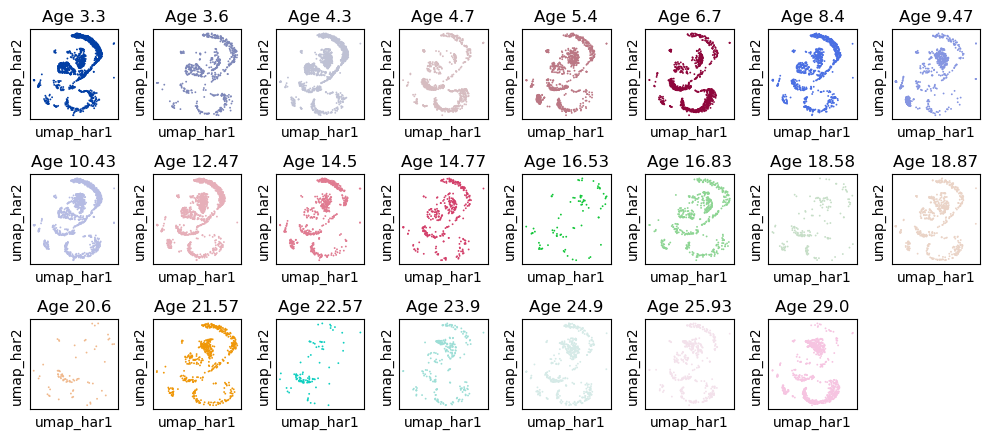

In [11]:
# Get unique ages and sort them
unique_ages = sorted(ad.obs['Age_cat'].unique())  # Sort unique ages in increasing order

num_ages = len(unique_ages)
ncols = 8
nrows = (num_ages + ncols - 1) // ncols  # Calculate the number of rows required

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 1.5 * nrows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each age and its corresponding subplot
for i, age in enumerate(unique_ages):
    # Filter the data for the current age category
    ad_age_filtered = ad[ad.obs['Age_cat'] == age]
    
    # Plot UMAP for the current age category on the ith subplot
    sc.pl.embedding(ad_age_filtered, 
                    basis='umap_har', 
                    color='Age_cat', 
                    title=f'Age {age}', 
                    cmap='rocket', size=7, 
                    ax=axes[i], show=False, legend_loc=None)  # Pass the specific subplot axis and don't show immediately

# Hide any empty subplots (if there are any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plot
plt.tight_layout()
plt.savefig(f'{SPATH}/plots/age_umaps.png')
plt.show()

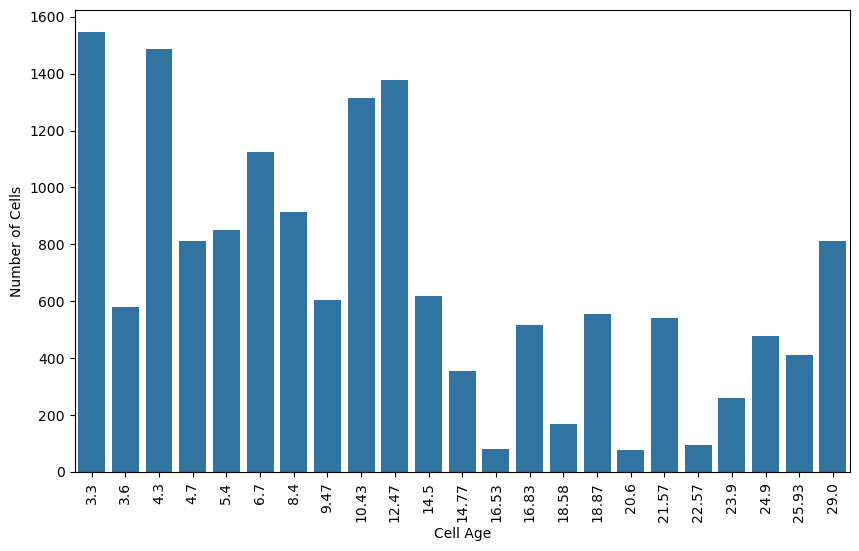

In [82]:
# Bar plot for cell type distribution
celltype_counts = ad.obs['Age_cat'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=celltype_counts.index, y=celltype_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Cell Age')
plt.ylabel('Number of Cells')
#plt.title('Distribution of Cells Across Age')
plt.savefig(f'{SPATH}/plots/cell_distribution_by_age.png')
plt.show()

#### NMF

In [14]:
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"3000/nmf_factors_iter=1000_rs=256_L={12}_rm(20.8, 22.6, 3.33)_new.npy")
loadings_path = path.join(nmf_save_path, f"3000/nmf_loadings_iter=1000_rs=256_L={12}_rm(20.8, 22.6, 3.33)_new.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
acf_idx, acf_val = putil.dims_autocorr_timeseries(factors)
factors = factors[:, acf_idx]
loadings = loadings[:, acf_idx]

In [15]:
print(factors.shape)
print(loadings.shape)

(15582, 12)
(3000, 12)


In [16]:
ad.obsm['X_nmf'] = factors
sc.pp.neighbors(ad, use_rep='X_nmf')
sc.tl.umap(ad)

2025-01-27 13:34:26.943404: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 13:34:26.957315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 13:34:26.972266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 13:34:26.972288: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 13:34:26.982012: I tensorflow/core/platform/cpu_feature_gua

In [17]:
factors.shape

(15582, 12)

In [18]:
loadings.shape

(3000, 12)

In [19]:
# Assuming `factors` is a 2D NumPy array
normalized_factors = (factors - factors.min(axis=0)) / (factors.max(axis=0) - factors.min(axis=0))

# Assign normalized columns back to ad.obs
for i in range(factors.shape[1]):  # Iterate over columns
    ad.obs[f'Factor {i+1}'] = normalized_factors[:, i]

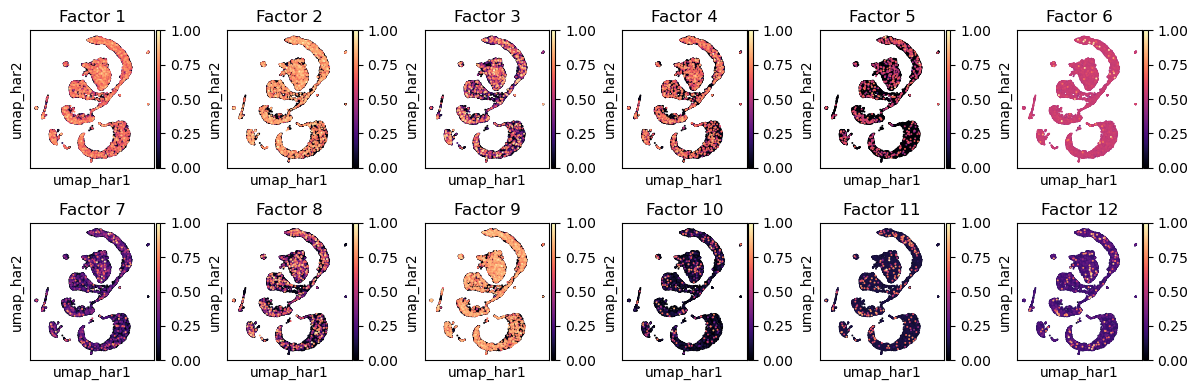

In [22]:
fig, ax = plot_umap_factors(loadings, ad)  
#fig.suptitle(f'Factors | sigma: {params["sigma"]}, lengthscale: {params["lengthscale"]}')
fig.savefig(f'{SPATH}/nmf_l=12_plot.png')

In [23]:
#filtered_values = ad.obs['Factor 1'][ad.obs['Factor 1'] > 0.75].tolist()
#len(filtered_values)

In [24]:
print(f"Shape of UMAP embeddings (ad.obsm['X_umap_har']): {ad.obsm['X_umap_har'].shape}")
print(f"Shape of loadings: {loadings.shape}")
print(f"Number of rows in ad.obs: {ad.obs.shape[0]}")

Shape of UMAP embeddings (ad.obsm['X_umap_har']): (15582, 2)
Shape of loadings: (3000, 12)
Number of rows in ad.obs: 15582


In [25]:
# Step 1: Reapply the filtering logic to extract filtered indices
# Load the original dataset
merpath = path.join(dpth, "merfish.h5ad")
ad_original = sc.read_h5ad(merpath)

# Apply the filtering logic to extract the filtered indices
ad_filtered_indices = ad_original.obs[
    (ad_original.obs['percent.mt'] < 5) &
    (ad_original.obs['nFeature_RNA'] >= 500) &
    (~ad_original.obs['Age'].isin([20.8, 22.6, 3.33]))
].index

# Subset the original AnnData object to match the filtered `loadings`
ad_filtered = ad_original[ad_original.obs.index.isin(ad_filtered_indices)]

# Step 2: Create the DataFrame for UMAP embeddings and Age categories
ad_filtered.obs['Age_cat'] = ad_filtered.obs['Age'].astype('category')
ages = sorted(ad.obs['Age_cat'].unique())

# Loop over each age and its corresponding subplot
age_map_dict = {}
for age in ages:
    # Filter the data for the current age category
    ad_age_filtered = ad[ad_filtered.obs['Age_cat'] == age]
    ad_age_filtered_umap = ad_age_filtered.obsm['X_umap_har'] # age separate UMAP
    age_map_dict[age] = ad_age_filtered_umap
    print(f"Age: {age} --> {ad_age_filtered_umap.shape}")
    #print(ad_age_filtered_umap)

/tmp/ipykernel_2062945/1651266991.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_filtered.obs['Age_cat'] = ad_filtered.obs['Age'].astype('category')


Age: 3.3 --> (1547, 2)
Age: 3.6 --> (581, 2)
Age: 4.3 --> (1488, 2)
Age: 4.7 --> (812, 2)
Age: 5.4 --> (852, 2)
Age: 6.7 --> (1126, 2)
Age: 8.4 --> (912, 2)
Age: 9.47 --> (603, 2)
Age: 10.43 --> (1314, 2)
Age: 12.47 --> (1377, 2)
Age: 14.5 --> (619, 2)
Age: 14.77 --> (355, 2)
Age: 16.53 --> (80, 2)
Age: 16.83 --> (517, 2)
Age: 18.58 --> (167, 2)
Age: 18.87 --> (556, 2)
Age: 20.6 --> (77, 2)
Age: 21.57 --> (542, 2)
Age: 22.57 --> (96, 2)
Age: 23.9 --> (261, 2)
Age: 24.9 --> (477, 2)
Age: 25.93 --> (412, 2)
Age: 29.0 --> (811, 2)


In [26]:
# Convert to percentages and sort by age category
age_percentages = (ad.obs['Age_cat'].value_counts() / len(ad.obs)) * 100

# Create a dictionary and sort it
# Assuming age categories are like '8pcw', '9pcw', etc.
age_distribution = dict(sorted(age_percentages.items()))

# Print the results in order
for age, percentage in age_distribution.items():
    print(f"{age}: {percentage:.2f}%")

3.3: 9.93%
3.6: 3.73%
4.3: 9.55%
4.7: 5.21%
5.4: 5.47%
6.7: 7.23%
8.4: 5.85%
9.47: 3.87%
10.43: 8.43%
12.47: 8.84%
14.5: 3.97%
14.77: 2.28%
16.53: 0.51%
16.83: 3.32%
18.58: 1.07%
18.87: 3.57%
20.6: 0.49%
21.57: 3.48%
22.57: 0.62%
23.9: 1.68%
24.9: 3.06%
25.93: 2.64%
29.0: 5.20%


In [27]:
L = loadings.shape[1]
harmony_umap_coords = ad.obsm['X_umap_har']
print(ad.obsm['X_umap_har'].shape)

factor_correlation_maps = {}
for i in range(1, L+1):
    print(f"Factor {i} --> {ad.obs[f'Factor {i}'].shape}")
    
    # Create a mask for cells with values above 0.50 for the current factor
    mask = ad.obs[f'Factor {i}'] > 0.50
    
    # Number of cells above the threshold for normalization
    num_cells_above_threshold = mask.sum()
    print(f"Number of cells above 0.50 for Factor {i}: {num_cells_above_threshold}")
    
    # Get the filtered values and UMAP coordinates
    filtered_values = ad.obs[f'Factor {i}'][mask]
    filtered_coords = harmony_umap_coords[mask, :]  # Apply the mask to the embedding coordinates
    
    factor_percentages = []
    for age in ages:
        dtype = [('x', float), ('y', float)]
        struct1 = np.array(list(map(tuple, filtered_coords)), dtype=dtype)
        struct2 = np.array(list(map(tuple, age_map_dict[age])), dtype=dtype)

        # Find unique coordinates in each array
        unique1 = np.unique(struct1)
        unique2 = np.unique(struct2)

        overlapping = np.intersect1d(unique1, unique2)
        overlapping_points = np.array([(point['x'], point['y']) for point in overlapping])
        all_points = np.union1d(unique1, unique2)
        
        # Calculate overlap percentages
        overlap_percentage = (len(overlapping) / len(unique1)) * 100 if len(unique1) > 0 else 0
        
        # Normalize by both the age distribution and the number of cells above the threshold
        normalized_overlap = overlap_percentage #/ age_distribution[age] #/ num_cells_above_threshold if age_distribution[age] > 0 and num_cells_above_threshold > 0 else 0
        print(f"Age {age} - Raw overlap: {overlap_percentage:.2f}%, Normalized: {normalized_overlap:.2f}")
        factor_percentages.append(normalized_overlap)
    
    # Store the normalized overlaps for the current factor
    factor_correlation_maps[i] = factor_percentages


(15582, 2)
Factor 1 --> (15582,)
Number of cells above 0.50 for Factor 1: 3717
Age 3.3 - Raw overlap: 15.74%, Normalized: 15.74
Age 3.6 - Raw overlap: 4.95%, Normalized: 4.95
Age 4.3 - Raw overlap: 12.94%, Normalized: 12.94
Age 4.7 - Raw overlap: 2.88%, Normalized: 2.88
Age 5.4 - Raw overlap: 4.22%, Normalized: 4.22
Age 6.7 - Raw overlap: 2.48%, Normalized: 2.48
Age 8.4 - Raw overlap: 7.53%, Normalized: 7.53
Age 9.47 - Raw overlap: 1.86%, Normalized: 1.86
Age 10.43 - Raw overlap: 10.28%, Normalized: 10.28
Age 12.47 - Raw overlap: 12.24%, Normalized: 12.24
Age 14.5 - Raw overlap: 4.82%, Normalized: 4.82
Age 14.77 - Raw overlap: 2.50%, Normalized: 2.50
Age 16.53 - Raw overlap: 0.48%, Normalized: 0.48
Age 16.83 - Raw overlap: 2.56%, Normalized: 2.56
Age 18.58 - Raw overlap: 0.54%, Normalized: 0.54
Age 18.87 - Raw overlap: 3.15%, Normalized: 3.15
Age 20.6 - Raw overlap: 0.19%, Normalized: 0.19
Age 21.57 - Raw overlap: 4.25%, Normalized: 4.25
Age 22.57 - Raw overlap: 0.30%, Normalized: 0.30

/tmp/ipykernel_2062945/2562543832.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  set2_colors = cm.get_cmap('Set2').colors


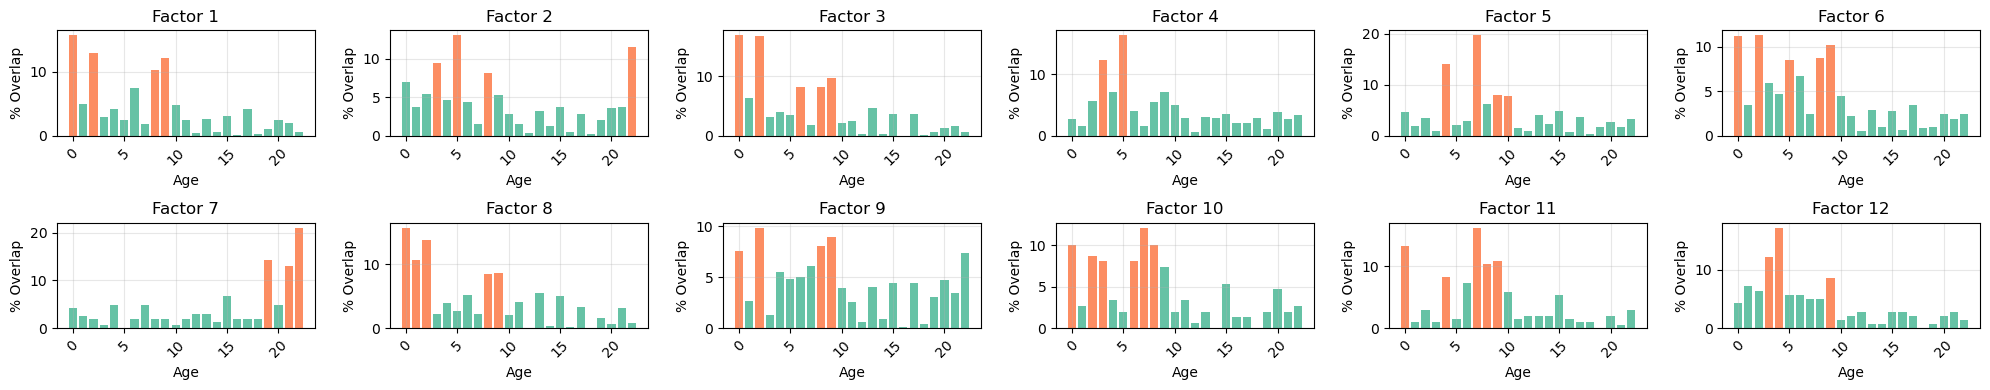

In [78]:
data_dict = factor_correlation_maps

# Calculate the number of subplots needed
n_plots = len(data_dict)

# Calculate number of rows and columns for subplot grid
n_cols = 6  # Adjust as needed
n_rows = (n_plots + n_cols - 1) // n_cols
    
# Find global min and max values for y-axis standardization
all_values = [val for values in data_dict.values() for val in values]
y_min = min(all_values)
y_max = max(all_values)
    
# Add small padding to the y-axis limits
y_padding = (y_max - y_min) * 0.05
y_min -= y_padding
y_max += y_padding
    
# Create figure with subplots
fig = plt.figure(figsize=(20, 2*n_rows))
    
# Create each subplot
for idx, (key, values) in enumerate(data_dict.items(), 1):
    ax = fig.add_subplot(n_rows, n_cols, idx)
    
    # Calculate the average value for significance
    average_value = sum(values) / len(values) if values else 0
    
    # Create bar plot with color coding
    # Get Set2 colors from Matplotlib
    set2_colors = cm.get_cmap('Set2').colors
    
    # Example color mapping using Set2 colors
    bar_colors = [
        set2_colors[1] if val > 1.75 * average_value else set2_colors[0]
        for val in values
]
    bars = ax.bar(range(len(values)), values, color=bar_colors)
        
    # Set consistent y-axis limits
    #ax.set_ylim(y_min, y_max)
        
    # Customize plot
    ax.set_title(f'Factor {key}')
    ax.set_xlabel('Age')
    ax.set_ylabel('% Overlap')
        
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
        
    # Rotate x-axis labels if there are many bars
    if len(values) > 10:
        plt.setp(ax.get_xticklabels(), rotation=45)
    
# Adjust layout to prevent overlap
plt.tight_layout()
fig.savefig(f'{SPATH}/l=12_age_overlap_distribution_per_factor.png')

In [30]:
# Data preparation for violin plot
all_data = []
L = len(factor_correlation_maps)  # Number of factors

for i in range(1, L+1):
    print(f"Processing Factor {i}")
        
    # Create a mask for cells with values above 0.50 for the current factor
    mask = ad.obs[f'Factor {i}'] > 0.50
    filtered_coords = harmony_umap_coords[mask, :]  # Apply the mask to the embedding coordinates

    for coord in filtered_coords:
        for age, age_coords in age_map_dict.items():
            if tuple(coord) in map(tuple, age_coords):  # Check if the coordinate matches the age group
                all_data.append({
                        'Factor': f'Factor {i}',
                        'Age': age
                })
                break
    
# Convert the data to a pandas DataFrame
df = pd.DataFrame(all_data)

Processing Factor 1
Processing Factor 2
Processing Factor 3
Processing Factor 4
Processing Factor 5
Processing Factor 6
Processing Factor 7
Processing Factor 8
Processing Factor 9
Processing Factor 10
Processing Factor 11
Processing Factor 12


/tmp/ipykernel_2062945/544882910.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_ages = df.groupby('Factor')['Age'].median().sort_values()
/tmp/ipykernel_2062945/544882910.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Factor', y='Age', data=df, palette='muted')


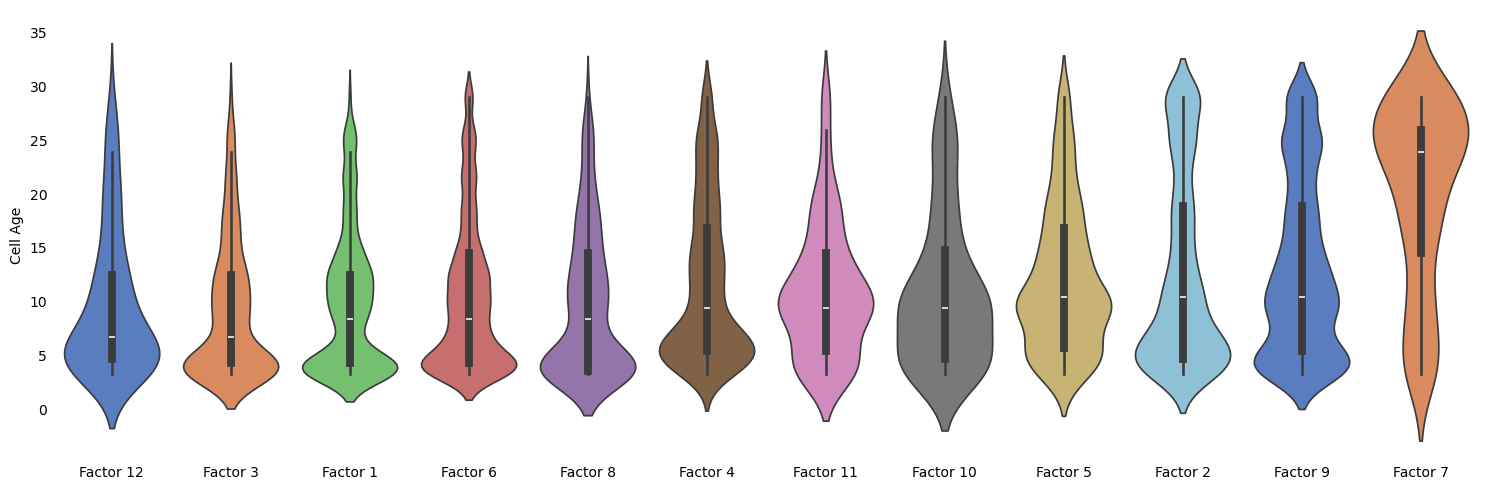

In [80]:
# Ensure 'Age' is a numeric type
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    
# Calculate the median age for each factor
median_ages = df.groupby('Factor')['Age'].median().sort_values()

# Reorder the factors based on median age
df['Factor'] = pd.Categorical(df['Factor'], categories=median_ages.index, ordered=True)

# Create the violin plot
plt.figure(figsize=(15, 5))
sns.violinplot(x='Factor', y='Age', data=df, palette='muted')
sns.despine(left=True, bottom=True)

# Remove tick marks from both axes
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)

plt.legend([], [], frameon=False)

plt.xlabel('')
plt.ylabel('Cell Age')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{SPATH}/plots/l=12_factor_age_distribution.png')
plt.show()

In [257]:
# Data preparation for violin plot with normalization
all_data = []
age_totals = {age: len(age_coords) for age, age_coords in age_map_dict.items()}  # Total coordinates per age
L = len(factor_correlation_maps)  # Number of factors

for i in range(1, L+1):
    print(f"Processing Factor {i}")
        
    # Create a mask for cells with values above 0.50 for the current factor
    mask = ad.obs[f'Factor {i}'] > 0.50
    filtered_coords = harmony_umap_coords[mask, :]  # Apply the mask to the embedding coordinates

    for coord in filtered_coords:
        for age, age_coords in age_map_dict.items():
            if tuple(coord) in map(tuple, age_coords):  # Check if the coordinate matches the age group
                normalized_value = 1 / age_totals[age]  # Normalize by total coordinates for that age
                all_data.append({
                    'Factor': f'Factor {i}',
                    'Age': age,
                    'Normalized Value': normalized_value
                })
                break
    
# Convert the data to a pandas DataFrame
df_age_normalized = pd.DataFrame(all_data)


Processing Factor 1
Processing Factor 2
Processing Factor 3
Processing Factor 4
Processing Factor 5
Processing Factor 6
Processing Factor 7
Processing Factor 8
Processing Factor 9
Processing Factor 10
Processing Factor 11
Processing Factor 12
Processing Factor 13
Processing Factor 14
Processing Factor 15
Processing Factor 16
Processing Factor 17
Processing Factor 18


/tmp/ipykernel_1925245/2479327623.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Factor', y='Normalized Value', data=df, palette='muted')


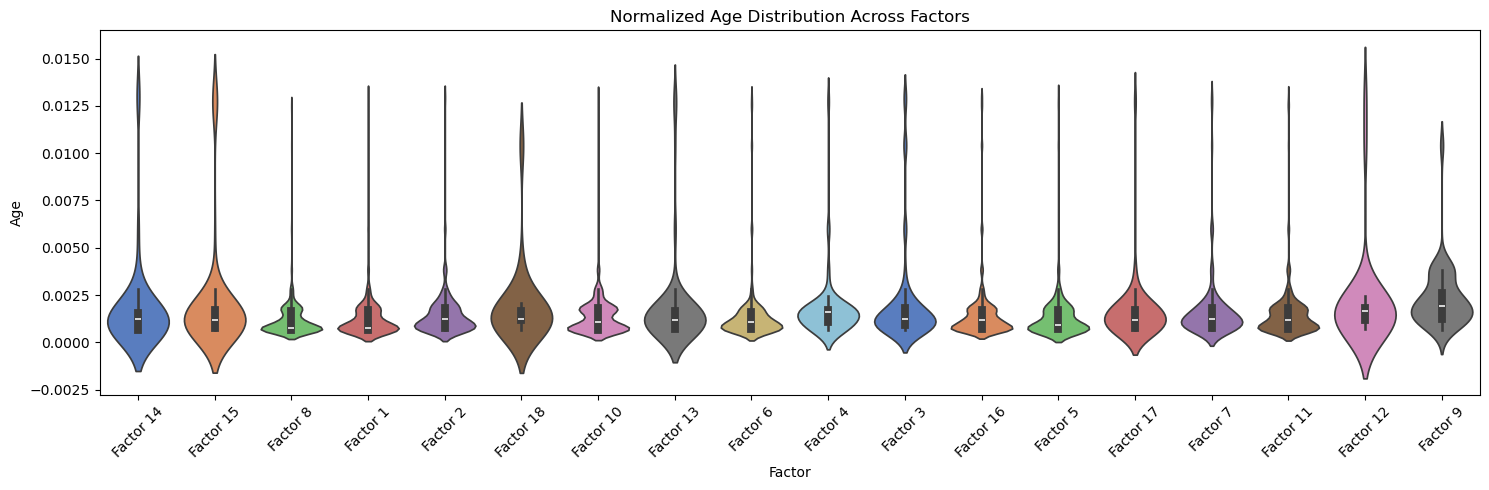

In [260]:
def plot_violin_with_normalization(df):
    """
    Create a violin plot showing the normalized distribution of factors across ages.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'Factor', 'Age', and 'Normalized Value' columns.
    """
    plt.figure(figsize=(15, 5))
    sns.violinplot(x='Factor', y='Normalized Value', data=df, palette='muted')
    plt.title('Normalized Age Distribution Across Factors')
    plt.xlabel('Factor')
    plt.ylabel('Age')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_violin_with_normalization(df_age_normalized)

In [27]:
params = {
        'L': 18, 
        'M': 1000, 
        'K': 8,
        'sigma': 0.3, 
        'lengthscale': 0.02, 
        'jtr': 0.01,
        'batch_size': 128,
        'lr': 0.01,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}

In [47]:
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"3000/nmf_factors_iter=1000_rs=256_L={18}_rm(20.8, 22.6, 3.33)_new.npy")
loadings_path = path.join(nmf_save_path, f"3000/nmf_loadings_iter=1000_rs=256_L={18}_rm(20.8, 22.6, 3.33)_new.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
acf_idx, acf_val = putil.dims_autocorr_timeseries(factors)
factors = factors[:, acf_idx]
loadings = loadings[:, acf_idx]

In [48]:
NNNSF = putil.build_model(np.array(X), np.array(Y), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=params)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (1000). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [49]:
print(Y.shape)
print(X.shape)

(3000, 15582)
torch.Size([15582, 1])


In [50]:
print(factors.shape)
print(loadings.shape)

(15582, 18)
(3000, 18)


In [51]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

/tmp/ipykernel_874604/4251362955.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


In [52]:
#vnngp/results/merfish/nnnsf/VNNGP_K=8_lkzz=1_M=1000_L=6_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_model.pt
nnnsf_path = path.join(SPATH,'nnnsf') 
file_path = f"3000_d1_no_spatial_standardization_0/VNNGP_K={params['K']}_lkzz=1_M={params['M']}_L={params['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_state_dict.pth"
modelname = f"3000_d1_no_spatial_standardization_0/VNNGP_K={params['K']}_lkzz=1_M={params['M']}_L={params['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

In [53]:
NNNSF.cpu()
qF, _, _ = NNNSF.prior(X.cpu(), kwargs=params)
mean = torch.exp(qF.mean).detach().numpy()
W = (NNNSF.W).cpu()
W_transformed = nn.functional.softplus(W.T)
W_transformed = W_transformed.detach().numpy()
y_nnnsf = ((mean.T)).dot(W_transformed)

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()


In [54]:
ad.obsm['X_nnnsf'] = mean.T
sc.pp.neighbors(ad, use_rep='X_nnnsf')
sc.tl.umap(ad)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [57]:
for i in range((mean.T).shape[1]):
    ad.obs[f'Factor {i+1}'] = (mean.T)[:, i]

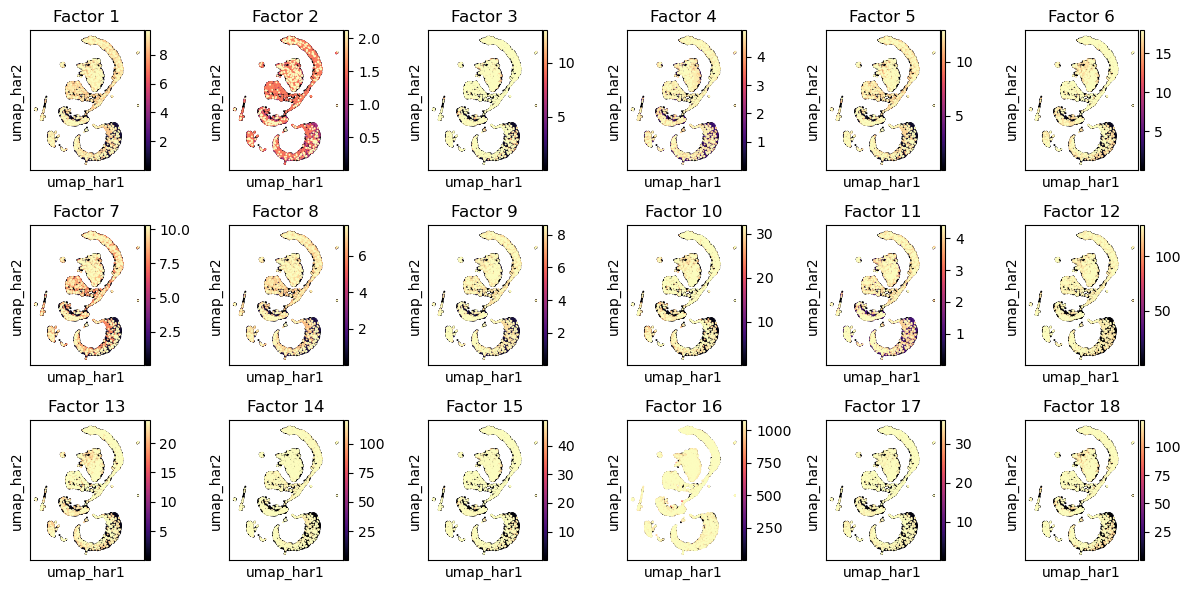

In [58]:
fig, ax = plot_umap_factors(loadings, ad)  
#fig.suptitle(f'Factors | sigma: {params["sigma"]}, lengthscale: {params["lengthscale"]}')
fig.savefig(f"{SPATH}/nnnsf_l={params['L']}_plot.png")

[3.3, 3.6, 4.3, 4.7, 5.4, 6.7, 8.4, 9.47, 10.43, 12.47, 14.5, 14.77, 16.53, 16.83, 18.58, 18.87, 20.6, 21.57, 22.57, 23.9, 24.9, 25.93, 29.0]


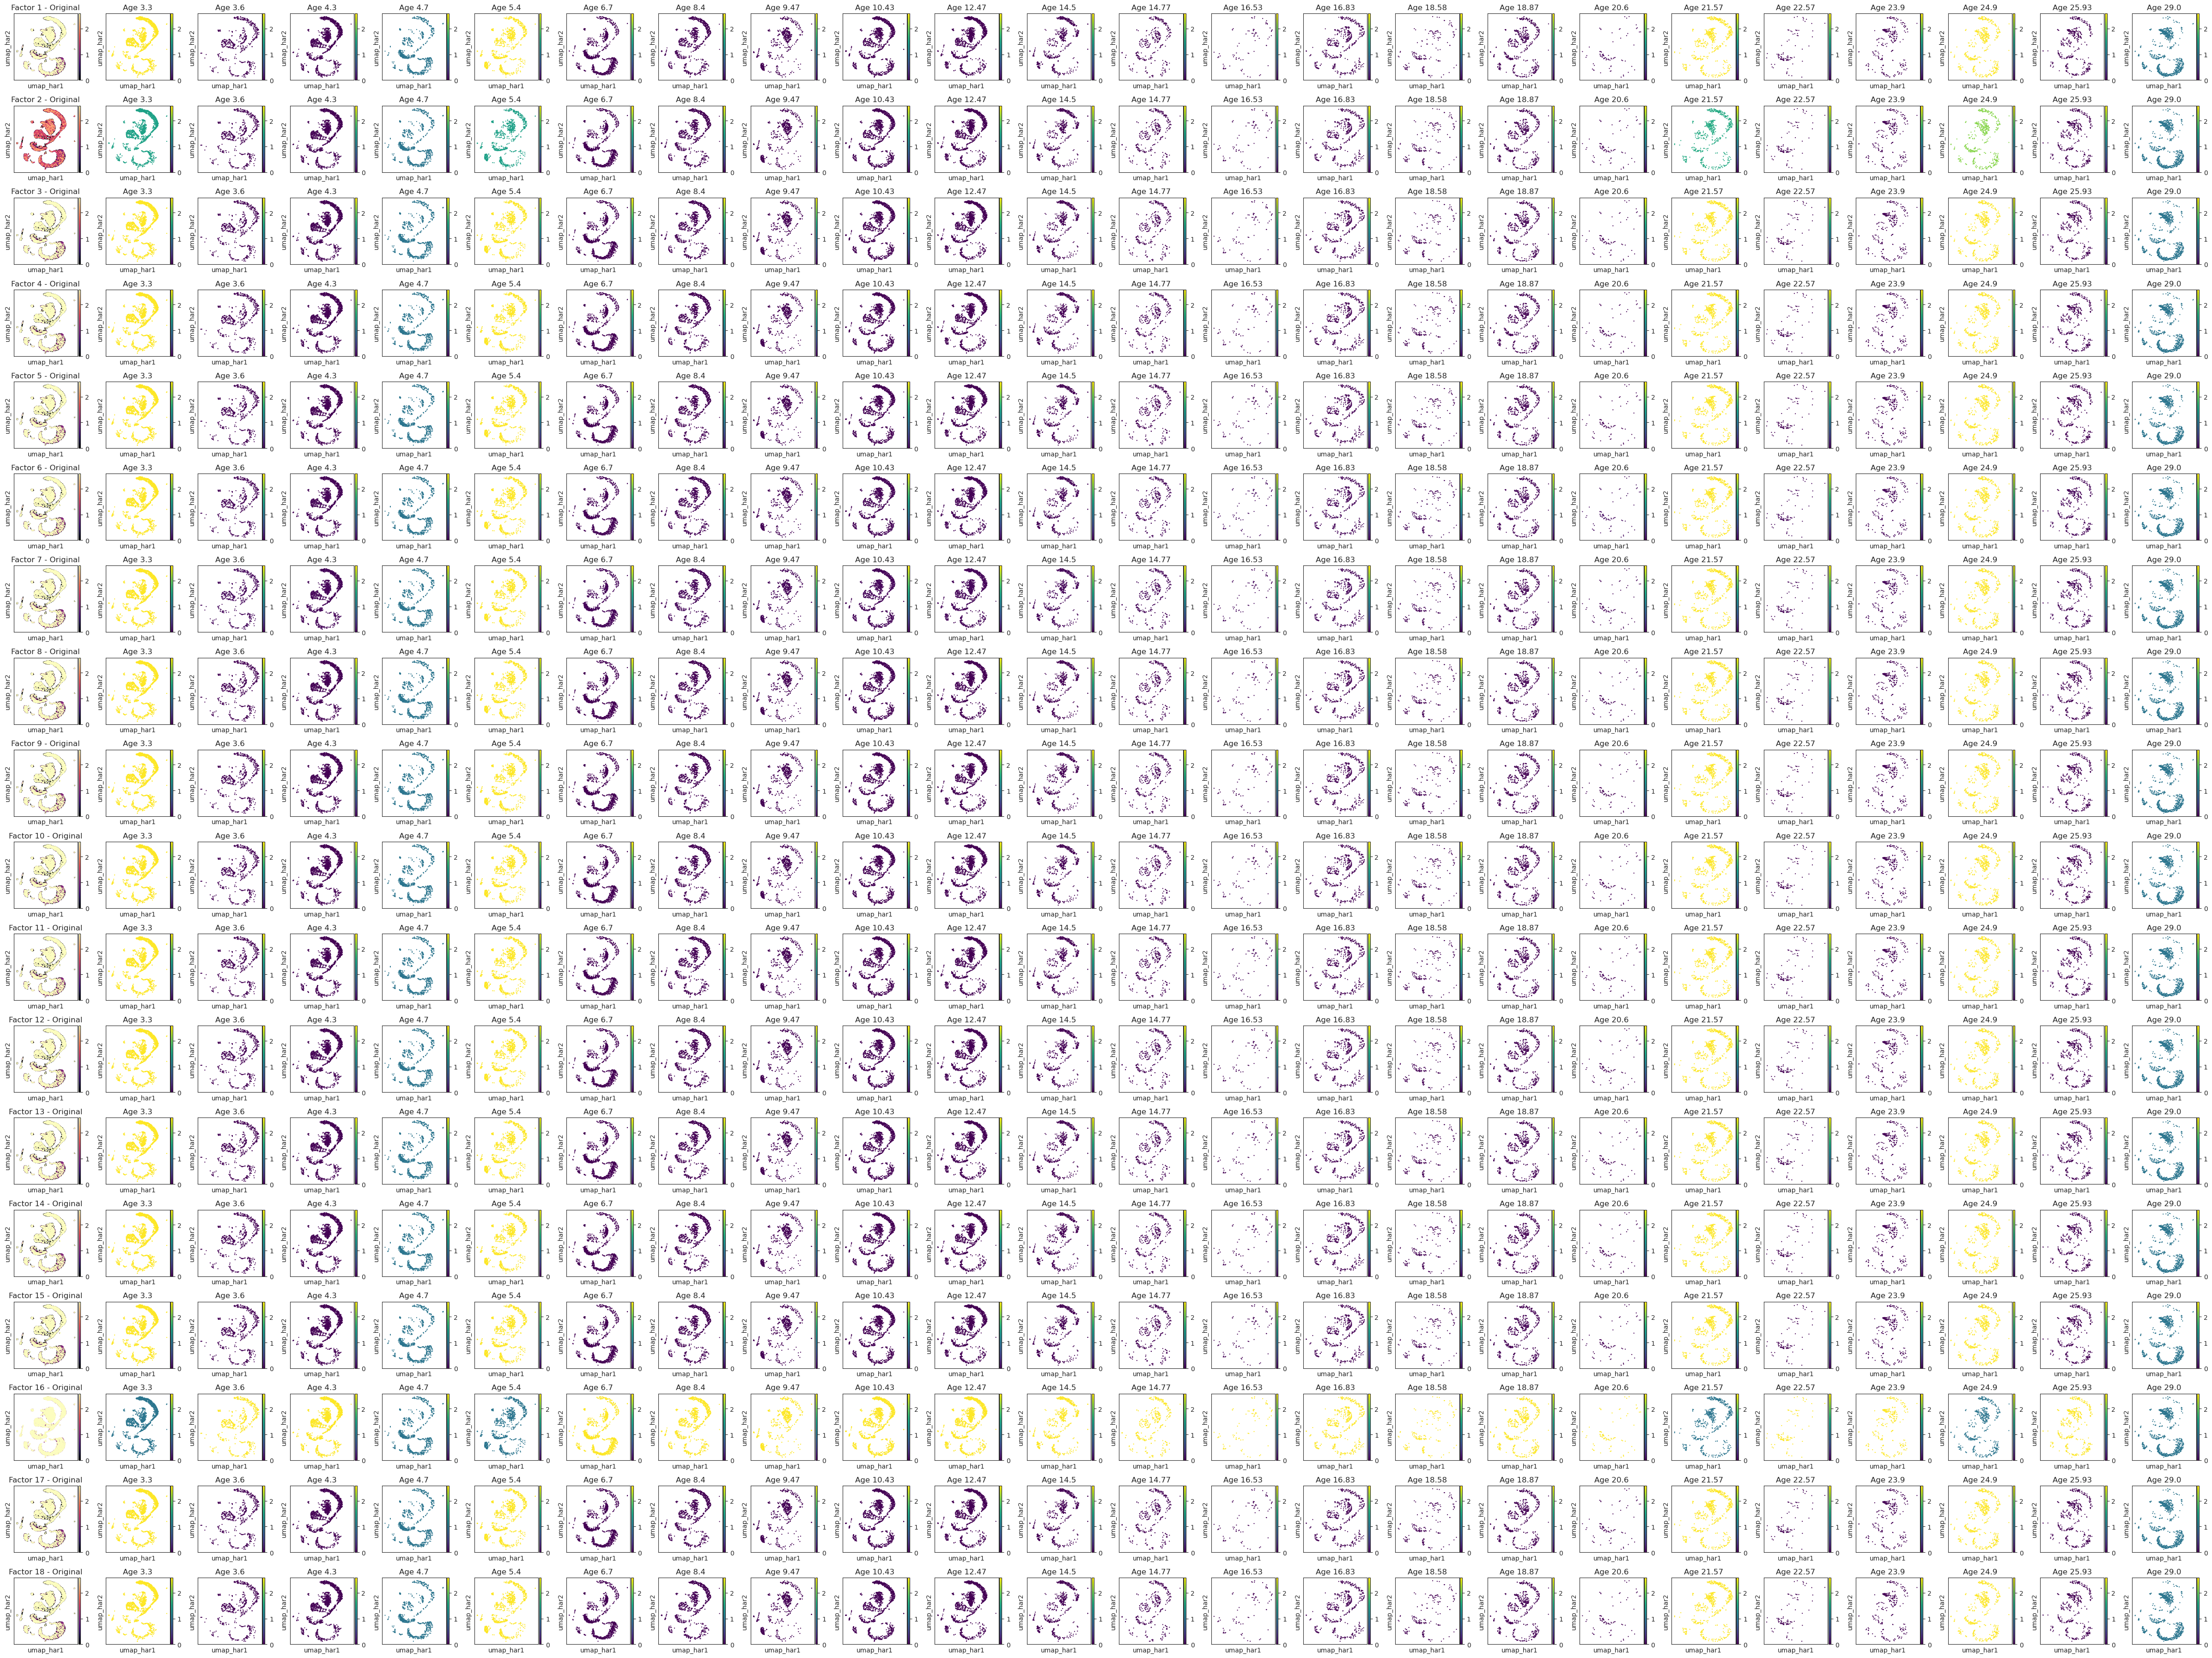

In [107]:
fig = plot_umap_factors_by_age(loadings, ad)
fig.savefig(f"{SPATH}/nnnsf_l={params['L']}_age_plot.png")

In [64]:
# Create a DataFrame for loadings and assign gene names as index
loadings_df = pd.DataFrame(W_transformed.T, index=ad.var_names)

# Get the top 10 genes for each factor
top_genes = {}

for factor in range(loadings_df.shape[1]):
    # Sort genes by loadings in descending order for this factor
    sorted_genes = loadings_df.iloc[:, factor].sort_values(ascending=False)
    
    # Get the top 10 genes
    top_genes[f'Factor_{factor+1}'] = sorted_genes.head(10).index.tolist()

# Convert the result into a DataFrame to visualize
top_genes_df = pd.DataFrame(top_genes)
print(top_genes_df)

  Factor_1 Factor_2       Factor_3       Factor_4       Factor_5   Factor_6  \
0      Lxn     Rgs2        Atp13a5         Phf11d           Drd1      Nipa1   
1    Bcas1  Gm13889         Galnt6          Otogl           Vsir      Orai1   
2   Rab33a    Vcam1         Phldb1         Mcemp1       Hist1h4h       Bex2   
3  Gm47093   Pcdh18        St8sia2          Slfn8          Il1r1  Serpina3n   
4    Orai1     Ano4        Gm17056        Khdrbs3          Lair1      Cetn4   
5  Gm16143      Ngp         Ifitm2          Fbln7          Bcas1       Cd93   
6   Cfap45    Olfm5  A330102I10Rik           Pllp  1110017D15Rik      H2-K1   
7   Lhfpl3    Cd1d1          Aurkb          Cxadr            Lxn    Rassf10   
8     Fgd2     Glul          Tgfbi  E130114P18Rik          Fxyd6      Ywhaq   
9    Il1r1   Podxl2        Camk2n1        Ppp1r3g           Rtn4   Tmem255b   

   Factor_7 Factor_8 Factor_9 Factor_10 Factor_11 Factor_12 Factor_13  \
0     Vcam1   Angpt2  Slc38a5   Racgap1   Atp13a5      He

In [65]:
top_genes_indices = {}

# Loop through each factor in top_genes_df
for factor in top_genes_df.columns:
    # Get the gene names for the factor
    genes = top_genes_df[factor]
    
    # Find the corresponding indices of these genes in ad.var_names
    indices = [list(ad.var_names).index(gene) for gene in genes]
    
    # Store the indices in the dictionary
    top_genes_indices[factor] = indices

# Convert the dictionary to a DataFrame for easier viewing
top_genes_indices_df = pd.DataFrame(top_genes_indices)
print(top_genes_indices_df)

   Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Factor_6  Factor_7  \
0       522       251       398      1533      2477      1548       505   
1      1100       362      1701      2539       268      1171      2916   
2      1745       505      1815      2538      2271       606      2638   
3      2762      1927      1234      1680      2298      1490      1994   
4      1171      2201      2149       496       346      2337      1526   
5      2586      2977       335      2626      1100       826      1277   
6      2309      2916      1703       429      2440       233       284   
7       563       912       779      1199       522      1660       528   
8      1033       541      2012      1142       448      1277       935   
9      2298       635      1390      1021      1038      2480      2892   

   Factor_8  Factor_9  Factor_10  Factor_11  Factor_12  Factor_13  Factor_14  \
0      2280       822        427        398        866        936        114   
1      1952   

In [66]:
unique_ages

array([ 3.3 ,  3.6 ,  4.3 ,  4.7 ,  5.4 ,  6.7 ,  8.4 ,  9.47, 10.43,
       12.47, 14.5 , 14.77, 16.53, 16.83, 18.58, 18.87, 20.6 , 21.57,
       22.57, 23.9 , 24.9 , 25.93, 29.  ])

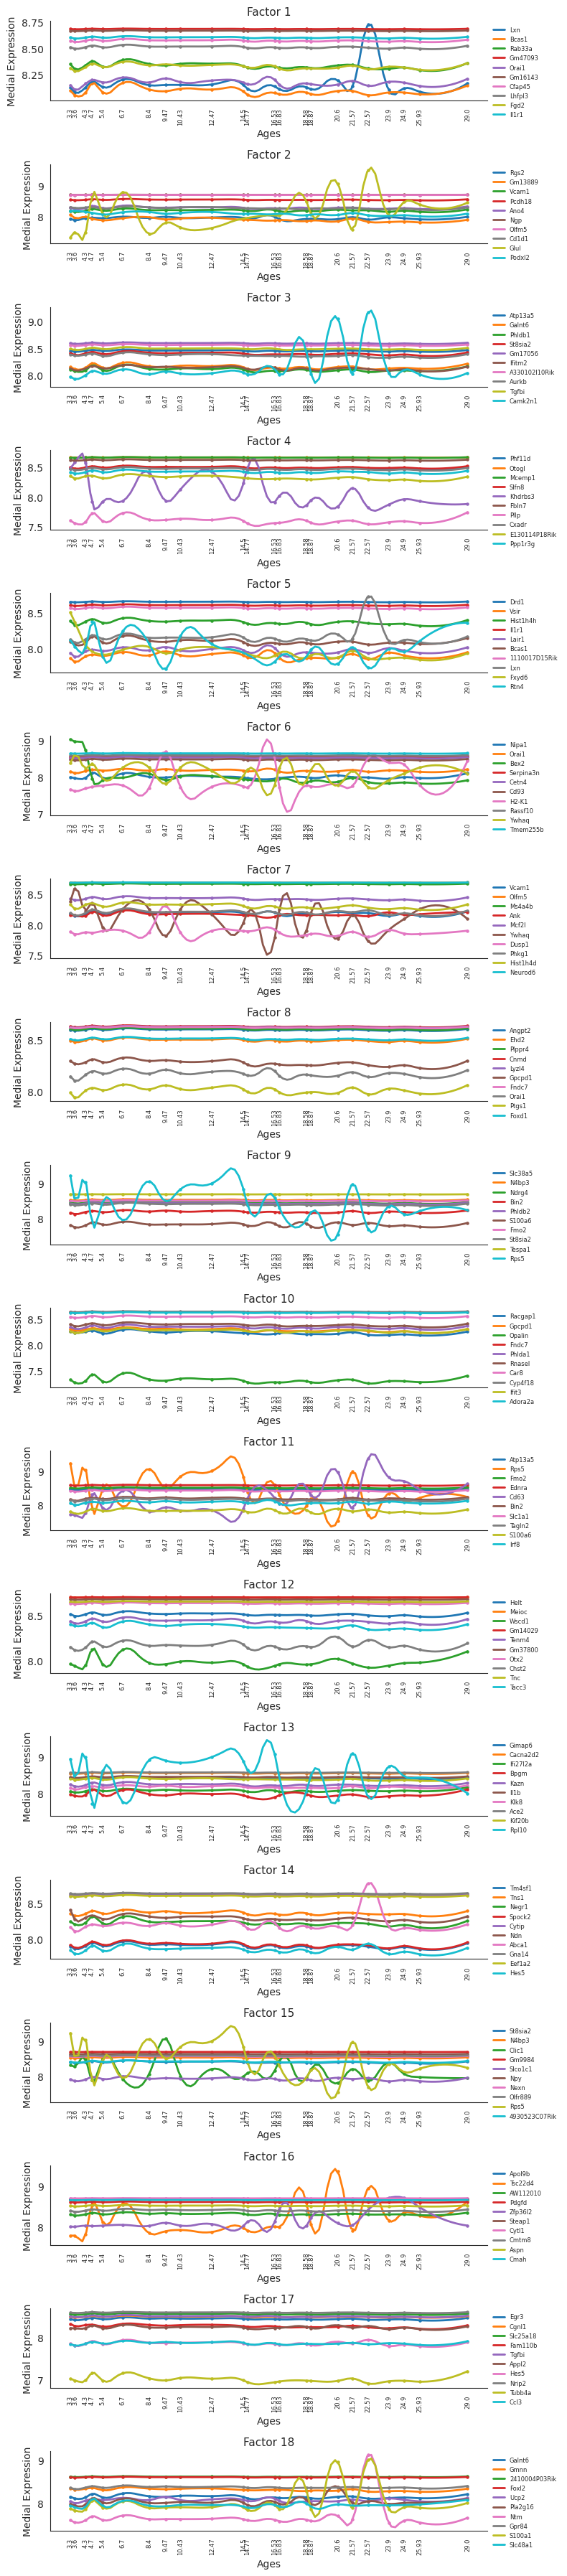

In [77]:
from scipy.interpolate import interp1d

L = (W_transformed.T).shape[1]  # Number of factors
size = 2
fig, axes = plt.subplots(18, 1, figsize=(size*4, size*18), tight_layout=False)

sns.set_style("white")

for i in range(L):
    #print(f"Plotting factor {i}")
    top_genes = top_genes_indices_df[f'Factor_{i+1}']
    gene_names = ad.var_names[top_genes].to_list()
    gene_data = ad[:, top_genes].X

    df = pd.DataFrame(gene_data, columns=gene_names)
    df['Age'] = ad.obs['Age'].values
    
    df_aggregated = df.groupby('Age')[gene_names].median().reset_index()
    curr_ax = axes[i % 18]
    
    df_melted = pd.melt(df_aggregated, id_vars=['Age'], value_vars=gene_names, 
                        var_name='Gene', value_name='Expression')

    # Interpolate to create smoother lines
    for gene in gene_names:
        subset = df_melted[df_melted['Gene'] == gene]
        x = subset['Age']
        y = subset['Expression']
        f = interp1d(x, y, kind='quadratic')
        
        # Generate more points to make a smoother curve
        x_new = np.linspace(x.min(), x.max(), 100)
        y_smooth = f(x_new)
        
        curr_ax.plot(x_new, y_smooth, label=gene, linewidth=2)
        curr_ax.scatter(x, y, s=5)
        curr_ax.set_xlabel("Ages")
        curr_ax.set_ylabel("Medial Expression")

    unique_ages = df_aggregated['Age'].unique()
    middle_age = unique_ages[len(unique_ages) // 2]
    tick_ages = [unique_ages[0], middle_age, unique_ages[-1]]
    
    curr_ax.set_xticks(unique_ages)
    #tick_labels = ['' for _ in unique_ages]
    #tick_labels[0] = unique_ages[0]
    #tick_labels[len(unique_ages) // 2] = middle_age
    #tick_labels[-1] = unique_ages[-1]
    
    curr_ax.set_xticklabels(unique_ages, rotation=90, fontsize=6)
    curr_ax.set_title(f"Factor {i+1}", size=11)
    sns.despine(ax=curr_ax)
    curr_ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=6)

plt.subplots_adjust(hspace=0.7)  # Adjust spacing between plots
#plt.savefig(f'{SPATH}/nnnsf/{file_path}_median_expression_nnnsf_original.png')
plt.show()

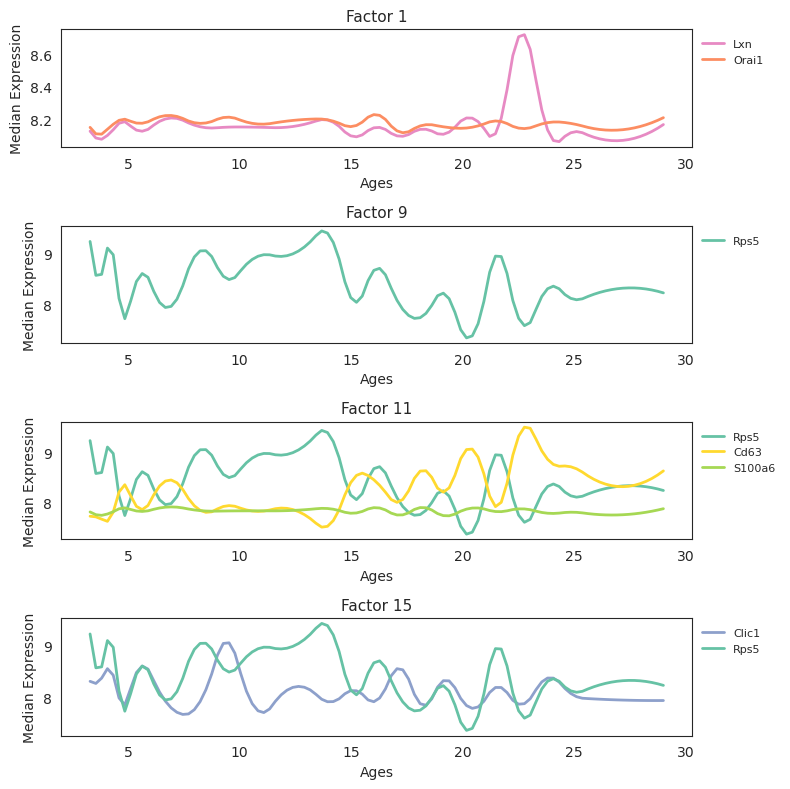

In [106]:
# Dictionary mapping each factor to a list of genes to exclude
genes_to_exclude_by_factor = {
    0: ['Gm47093', 'Gm16143', 'Cfap45', 'Il1r1', 'Lhfpl3', 'Rab33a', 'Fgd2', 'Bcas1'], 
    1: ['Rgs2', 'Gm13889', 'Vcam1', 'Pcdh18', 'Ano4', 'Ngp', 'Olfm5', 'Podxl2', 'Cd1d1'],  
    2: ['Atp13a5', 'Galnt6', 'Phldb1', 'St8sia2', 'Gm17056', 'Ifitm2', 'A330102I10Rik', 'Aurkb', 'Tgfbi'],
    3: ["Phf11d", "Otogl", "Mcemp1", "Slfn8", "Cxadr", "E130114P18Rik", "Ppp1r3g", 'Fbln7'],
    4: ['Drd1', 'Il1r1', '1110017D15Rik', 'Hist1h4h', 'Bcas1'],
    5: ['Nipa1', 'Orai1', 'Serpina3n', 'Cetn4', 'Cd93', 'Rassf10', 'Tmem255b'],
    6: ['Ms4a4b', 'Neurod6', 'Mcf2l', 'Hist1h4d', 'Phkg1', 'Ank', 'Vcam1', 'Olfm5'],
    7: ['Angpt2', 'Ehd2', 'Plppr4', 'Cnmd', 'Lyzl4', 'Fndc7', 'Foxd1', 'Gm12002'],
    8: ["Slc38a5", "N4bp3", "Ndrg4", "Bin2", "Phldb2", "S100a6", "Fmo2", "St8sia2", "Tespa1"],
    10: ['Atp13a5', 'Fmo2', 'Ednra', 'Bin2', 'Slc1a1', 'Tagln2', 'Irf8'],
    11: ['Helt', 'Meioc', 'Gm14029', 'Tenm4', 'Gm37800', 'Tacc3', 'Tnc', 'Otx2'],
    12: ["Gimap6", "Cacna2d2", "Ifi27l2a", "Bpgm", "Kazn", "Il1b", "Klk8", "Ace2", "Kif20b"],
    13: ['Tm4sf1', 'Cytip', 'Eef1a2', 'Gna14'],
    14: ['St8sia2', 'N4bp3', 'Gm9984', 'Slco1c1', 'Npy', 'Nexn', 'Olfr889', '4930523C07Rik'],
    15: ['Apol9b', 'AW112010', 'Pdgfd', 'Steap1', 'Cytl1', 'Cmtm8', 'Aspn', 'Cmah'],
    17: ['Galnt6', 'Gmnn', '2410004P03Rik', 'Foxl2', 'Ucp2', 'Gpr84'],
}

F = [0, 8, 10, 14]  # Factors to plot

# Gather all unique genes to assign consistent colors
all_genes = set()
for factor in F:
    top_genes = top_genes_indices_df[f'Factor_{factor+1}']
    gene_names = ad.var_names[top_genes].to_list()
    genes_to_exclude = genes_to_exclude_by_factor.get(factor, [])
    gene_names = [gene for gene in gene_names if gene not in genes_to_exclude]
    all_genes.update(gene_names)

# Create a consistent color mapping using the Set2 palette
palette = sns.color_palette("Set2", len(all_genes))
gene_to_color = dict(zip(all_genes, palette))

# Dynamically create subplots based on the number of factors
num_plots = len(F)
size = 2
fig, axes = plt.subplots(num_plots, 1, figsize=(size*4, size*num_plots), tight_layout=False)
if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable for a single plot

sns.set_style("white")

for idx, i in enumerate(F):
    top_genes = top_genes_indices_df[f'Factor_{i+1}']
    gene_names = ad.var_names[top_genes].to_list()
    
    # Remove specific genes for the current factor if specified in the dictionary
    genes_to_exclude = genes_to_exclude_by_factor.get(i, [])
    gene_names = [gene for gene in gene_names if gene not in genes_to_exclude]
    
    # Subset the data matrix to the filtered top genes for Factor i+1
    gene_data = ad[:, [ad.var_names.get_loc(g) for g in gene_names]].X

    # Create a DataFrame to combine the top genes and relevant metadata
    df = pd.DataFrame(gene_data, columns=gene_names)
    df['Age'] = ad.obs['Age'].values
    
    df_aggregated = df.groupby('Age')[gene_names].median().reset_index()
    curr_ax = axes[idx]  # Use the appropriate subplot
    
    df_melted = pd.melt(df_aggregated, id_vars=['Age'], value_vars=gene_names, 
                        var_name='Gene', value_name='Expression')

    # Interpolate to create smoother lines
    for gene in gene_names:
        subset = df_melted[df_melted['Gene'] == gene]
        x = subset['Age']
        y = subset['Expression']
        f = interp1d(x, y, kind='quadratic')
        
        # Generate more points to make a smoother curve
        x_new = np.linspace(x.min(), x.max(), 100)
        y_smooth = f(x_new)
        
        # Plot the smoothed curve
        curr_ax.plot(x_new, y_smooth, label=gene, linewidth=2, color=gene_to_color[gene])
        curr_ax.set_xlabel("Ages")
        curr_ax.set_ylabel("Median Expression")

    curr_ax.set_title(f"Factor {i+1}", size=11)
    curr_ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=8)
    #sns.despine(ax=curr_ax)

plt.subplots_adjust(hspace=0.7)  # Adjust spacing between plots
plt.savefig(f'{SPATH}/median_expression_nnnsf_selected.png')
plt.show()

In [12]:
nsf_path

'/engelhardt/home/pshrestha/vnngp/results/merfish/nsf'

In [64]:
L = [6, 12, 18]
nsf_losses = []
for i in L:
    params = {
        'L': i, 
        'M': 500,
        'K': 8,
        'sigma': 0.3, 
        'lengthscale': 0.02, 
        'jtr': 0.01,
        'batch_size': 64,
        'lr': 0.01,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}
    modelname = f"SVGP_M={params['M']}_L={i}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_model.pt"
    dict_path = path.join(nsf_path, modelname)
    model_path = path.join(nsf_path, modelname)
    nsf_model_dict = torch.load(model_path)
    nsf_losses.append(nsf_model_dict['losses'])

In [77]:
L = [6, 12, 18]
nnnsf_losses = []
for i in L:
    params = {
        'L': i, 
        'M': 1000,
        'K': 8,
        'sigma': 0.3, 
        'lengthscale': 0.02, 
        'jtr': 0.01,
        'batch_size': 64,
        'lr': 0.01,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}
    #vnngp/results/merfish/nnnsf/3000_d1_no_spatial_standardization_0
    modelname = f"3000_d1_no_spatial_standardization_0/VNNGP_K={params['K']}_lkzz=1_M={params['M']}_L={params['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_model.pt"
    dict_path = path.join(nnnsf_path, modelname)
    model_path = path.join(nnnsf_path, modelname)
    nnnsf_model_dict = torch.load(model_path)
    nnnsf_losses.append(nnnsf_model_dict['losses'])

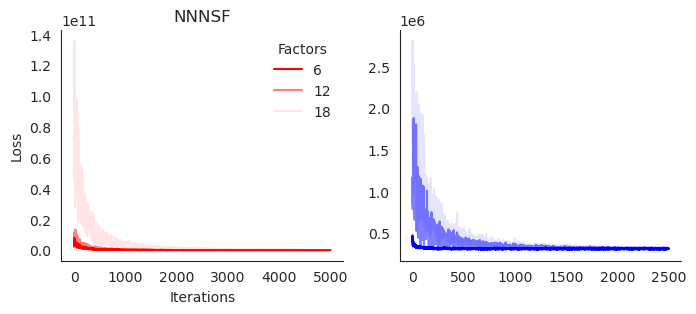

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.set_style("white")

# NSF Losses
ax[1].plot(nsf_losses[0], alpha=1.0, color='blue', label='6')
ax[1].plot(nsf_losses[1], alpha=0.5, color='blue', label='12')
ax[1].plot(nsf_losses[2], alpha=0.1, color='blue', label='18')
#ax[0].set_xlabel("Iterations")
#ax[0].set_ylabel("Loss")
#ax[0].set_title("NSF")
#ax[0].legend(title="Factors", frameon=False)  # Add legend with a title

# NNNSF Losses
ax[0].plot(nnnsf_losses[0], alpha=1.0, color='red', label='6')
ax[0].plot(nnnsf_losses[1], alpha=0.5, color='red', label='12')
ax[0].plot(nnnsf_losses[2], alpha=0.1, color='red', label='18')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].set_title("NNNSF")
ax[0].legend(title="Factors", frameon=False)  # Add legend with a title

# Remove spines
sns.despine(fig=fig)  # Removes all spines from both subplots

#fig.suptitle(f"VNNGP Loss by Factor")
plt.show()
#fig.savefig(f'{SPATH}/merfish_loss.png')

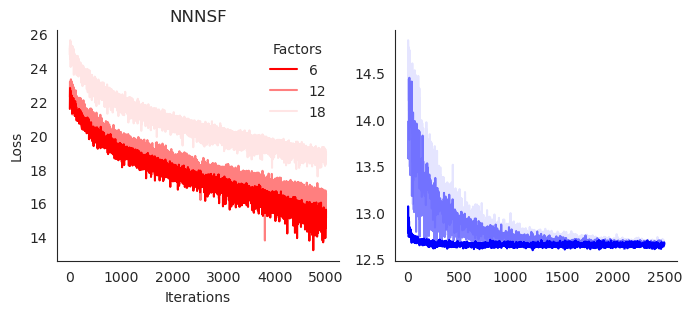

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.set_style("white")

# NSF Losses
ax[1].plot(np.log(nsf_losses[0]), alpha=1.0, color='blue', label='6')
ax[1].plot(np.log(nsf_losses[1]), alpha=0.5, color='blue', label='12')
ax[1].plot(np.log(nsf_losses[2]), alpha=0.1, color='blue', label='18')
#ax[0].set_xlabel("Iterations")
#ax[0].set_ylabel("Loss")
#ax[0].set_title("NSF")
#ax[0].legend(title="Factors", frameon=False)  # Add legend with a title

# NNNSF Losses
ax[0].plot(np.log(nnnsf_losses[0]), alpha=1.0, color='red', label='6')
ax[0].plot(np.log(nnnsf_losses[1]), alpha=0.5, color='red', label='12')
ax[0].plot(np.log(nnnsf_losses[2]), alpha=0.1, color='red', label='18')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].set_title("NNNSF")
ax[0].legend(title="Factors", frameon=False)  # Add legend with a title

# Remove spines
sns.despine(fig=fig)  # Removes all spines from both subplots

#fig.suptitle(f"VNNGP Loss by Factor")
plt.show()
#fig.savefig(f'{SPATH}/merfish_loss.png')

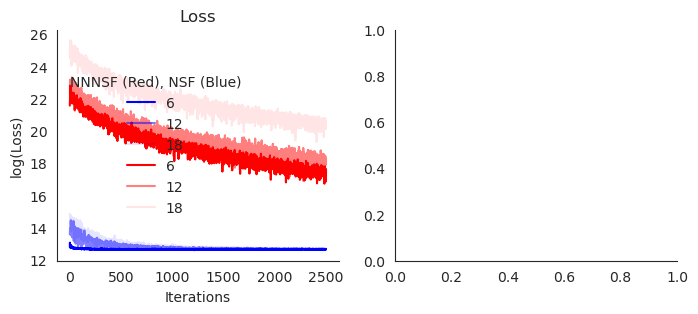

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.set_style("white")

# NSF Losses
ax[0].plot(np.log(nsf_losses[0]), alpha=1.0, color='blue', label='6')
ax[0].plot(np.log(nsf_losses[1]), alpha=0.5, color='blue', label='12')
ax[0].plot(np.log(nsf_losses[2]), alpha=0.1, color='blue', label='18')
#ax[0].set_xlabel("Iterations")
#ax[0].set_ylabel("Loss")
#ax[0].set_title("NSF")
#ax[0].legend(title="Factors", frameon=False)  # Add legend with a title

# NNNSF Losses
ax[0].plot(np.log(nnnsf_losses[0][0:2500]), alpha=1.0, color='red', label='6')
ax[0].plot(np.log(nnnsf_losses[1][0:2500]), alpha=0.5, color='red', label='12')
ax[0].plot(np.log(nnnsf_losses[2][0:2500]), alpha=0.1, color='red', label='18')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("log(Loss)")
ax[0].set_title("Loss")
ax[0].legend(title="NNNSF (Red), NSF (Blue)", frameon=False)  # Add legend with a title

# Remove spines
sns.despine(fig=fig)  # Removes all spines from both subplots

#fig.suptitle(f"VNNGP Loss by Factor")
plt.show()
#fig.savefig(f'{SPATH}/merfish_loss.png')

In [156]:
nnnsf_model_dict['time']
#len(nnnsf_model_dict['losses'])

1013.1611225605011

In [155]:
nsf_model_dict['time']
#len(nsf_model_dict['losses'])

305.69387316703796